# Final Homework TB3 Image and Pattern Recognition, asymmetrical moles application.

Library imports

In [ ]:
from numpy.ma.core import flatten_mask
import numpy as np
from skimage.measure import label, regionprops, regionprops_table
from skimage import data, filters, measure, morphology
from skimage.io import imread
from skimage import util
import cv2
from skimage.measure import label, regionprops
from skimage.morphology import erosion, dilation, opening, closing, skeletonize, convex_hull_image
from skimage.filters import gabor
from skimage.feature import local_binary_pattern, greycomatrix, greycoprops
from skimage.transform import rescale
import numpy as np
from skimage.measure import label, regionprops
from skimage.morphology import erosion, convex_hull_image, skeletonize
from google.colab.patches import cv2_imshow
import pandas as pd
from scipy.stats import skew
import skimage
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [ ]:
#!unzip /content/PROJECT_Data.zip

In [ ]:
dfinfo=pd.read_csv('/content/ISIC-2017_Data_GroundTruth_Classification.csv')

In [ ]:
dfinfo

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0000000,0.0,0.0
1,ISIC_0000001,0.0,0.0
2,ISIC_0000002,1.0,0.0
3,ISIC_0000003,0.0,0.0
4,ISIC_0000004,1.0,0.0
...,...,...,...
1995,ISIC_0015220,0.0,1.0
1996,ISIC_0015233,0.0,1.0
1997,ISIC_0015260,0.0,1.0
1998,ISIC_0015284,1.0,0.0


In [ ]:
import glob
import os

def list_prefixes(repo_path):
    # Use glob to find all files in the repository
    file_list = glob.glob(os.path.join(repo_path, "*"))
    
    # Get the prefixes of the files
    prefixes = []
    for file in file_list:
        name = os.path.basename(file)
        prefix, _ = name.split(".")
        prefix_parts = prefix.split("_")
        if prefix_parts[0] == "ISIC":
            prefixes.append(prefix_parts[0] + "_" + prefix_parts[1])
    prefixes = list(set(prefixes))
    
    # Return the list of prefixes
    return prefixes




In [ ]:
listimage=list_prefixes('/content/PROJECT_Data') #getting all the images id inside project Data

In [ ]:
dfinfo=dfinfo[dfinfo["image_id"].isin(listimage)] #getting all the rows of the dataframe for the image ids that we have

In [ ]:
dfinfo #printing the dataframe

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0000000,0.0,0.0
1,ISIC_0000001,0.0,0.0
2,ISIC_0000002,1.0,0.0
3,ISIC_0000003,0.0,0.0
4,ISIC_0000004,1.0,0.0
...,...,...,...
414,ISIC_0000511,1.0,0.0
415,ISIC_0000513,1.0,0.0
418,ISIC_0000516,1.0,0.0
419,ISIC_0000517,1.0,0.0


In order to conduct this work, i will follow these steps :

1. Creation of the functions to extract features on the different images of the database (Morphological and Intensity/Texture features)

2. Extraction of these features on all the images of the dataset

3. Data visualization of the different informations inside our Data-Set

4. Train-Test split in order to proceed to the training of different models (SVM,KNN,DecisionTree,RandomForest,CNN)

5. Training of the models


6. Evaluation of the models


7. Conclusion



## 1 - Feature Extraction Function

In order to extract the different features within our images, i will create a function that take as an input a gray scale image and extract different features about it, the function will start by using a treshold to erase all the shape and information not wanted inside the image. We will then start computing the different metrics within the image and store it in a Dataframe that will be our output.

In [ ]:
def flatten(matrix): #function in order to flatten matrix when needed it
    return matrix.reshape(-1).T


def compute_features(image):
 
  #little function that helps to focus only on the mole using a filter and a mask
  threshold = filters.threshold_otsu(image)
  mask = image > threshold
  mask = morphology.remove_small_objects(mask, 50)
  mask = morphology.remove_small_holes(mask, 50)
  labels = measure.label(mask)    

  #creating the features for morphological informations

  shape_features = np.empty(shape=14)
  properties=[] #setting a list of properties that i will get
  properties.append("convex_area")  #computing convex area
  properties.append("eccentricity") #getting eccentricity
  properties.append("perimeter") #getting the perimeter
  properties.append('equivalent_diameter') #getting the equivalent diameter
  properties.append('extent') #getting the extent
  properties.append('filled_area') #getting the area approximation
  properties.append('minor_axis_length') #getting the minor axis_length
  properties.append('major_axis_length') #getting the major axis length
  properties.append('solidity') #getting the solidity
  properties.append('perimeter_crofton') #getting crofton perimeter
  properties.append('solidity') #getting solidity

  
  
  
  table = regionprops_table(labels,image, properties=properties)
  shape_features=pd.DataFrame(table)
  shape_features=shape_features.iloc[0] #only getting the most important region in order to reduce the computation time
  shape_features["axis_ratio"] = shape_features["major_axis_length"] / shape_features["minor_axis_length"]

  # Initialize dictionary to store the features about intensity and texture
  features_textures = {}
    
  # Extract intensity descriptors
  shape_features["mean_intensity"] = np.mean(image)
  shape_features["median_intensity"] = np.median(image)
  shape_features["std_intensity"] = np.std(image)
  shape_features["range_intensity"] = np.max(image) - np.min(image)
  shape_features["skewness_intensity"] = skew(image.flatten())
    
  # Extract texture descriptors using LBP
  LBP= local_binary_pattern(image, P=8, R=1)
  # Create the histogram
  hist, _ = np.histogram(LBP, bins=range(257))
  # Normalize the histogram
  hist = hist.astype("float")
  hist /= (hist.sum() + 1e-7)
  # Add the histogram to the dataframe
  shape_features["hist_LBP"] =hist.flatten()
  shape_features["mean_LBP"] = np.mean(LBP)
  shape_features["median_LBP"] = np.median(LBP)
  shape_features["std_LBP"] = np.std(LBP)
  shape_features["range_LBP"] = np.max(LBP) - np.min(LBP)
  shape_features["skewness_LBP"] = skew(LBP.flatten())
  shape_features=pd.DataFrame(data=shape_features)
  
  return shape_features.T
    




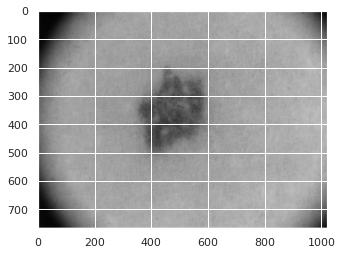

In [ ]:
img_ori = imread('/content/PROJECT_Data/ISIC_0000006.jpg')
image_2d = np.sum(img_ori, axis=2)
img = util.img_as_ubyte(image_2d)
image_2d = image_2d.astype(np.int64)
plt.imshow(image_2d,cmap='gray')
features = compute_features(image_2d)


In [ ]:
def flatten_arrays(df, array_columns):
    # Create a new dataframe with the same columns as the original
    df_flattened = df.copy()
    
    # Iterate over each row of the dataframe
    for index, row in df.iterrows():
        # Flatten the arrays in the specified columns
        features = []
        for col in array_columns:
            features.extend(row[col])

        # Add the new list of features to the dataframe as new columns
        for i, feature in enumerate(features):
            df_flattened.at[index, 'feature_' + str(i)] = feature
    
    return df_flattened


In [ ]:
features

,convex_area,eccentricity,perimeter,equivalent_diameter,extent,filled_area,minor_axis_length,major_axis_length,solidity,perimeter_crofton,...,median_intensity,std_intensity,range_intensity,skewness_intensity,hist_LBP,mean_LBP,median_LBP,std_LBP,range_LBP,skewness_LBP
0,783874.0,0.627381,6888.143541,926.274218,0.859652,783874.0,880.472668,1130.677917,0.859652,8184.571638,...,483.0,104.278944,765.0,-2.024932,"[0.013476655687009204, 0.011251808326336725, 0...",143.117058,135.0,88.406977,255.0,-0.226148


In [ ]:
features=flatten_arrays(features,['hist_LBP'])

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)


In [ ]:
features

,convex_area,eccentricity,perimeter,equivalent_diameter,extent,filled_area,minor_axis_length,major_axis_length,solidity,perimeter_crofton,...,feature_246,feature_247,feature_248,feature_249,feature_250,feature_251,feature_252,feature_253,feature_254,feature_255
0,783874.0,0.627381,6888.143541,926.274218,0.859652,783874.0,880.472668,1130.677917,0.859652,8184.571638,...,0.000223,0.008912,0.013108,0.01245,0.000068,0.008753,0.012866,0.00836,0.007178,0.084895


Now that we have the function, let's proceed to the feature extraction on the whole dataset.

## 2 - Feature Extraction on the Dataset

We now have to reccursively load images, extract features and store the information about the class in a dataframe that will concatenate all the informations, here is my code to do this step:

I start by creating a new dataframe df with the structure i want as output

In [ ]:
empty_df = features #creating a dataframe to have the same shape
empty_df['image_id']=0
empty_df['melanoma']=0
df= pd.DataFrame(columns=empty_df.columns, index=empty_df.index)
df

<ipython-input-290-c0607e715d42>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  empty_df['image_id']=0
<ipython-input-290-c0607e715d42>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  empty_df['melanoma']=0


,convex_area,eccentricity,perimeter,equivalent_diameter,extent,filled_area,minor_axis_length,major_axis_length,solidity,perimeter_crofton,...,feature_248,feature_249,feature_250,feature_251,feature_252,feature_253,feature_254,feature_255,image_id,melanoma
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


I then apply all the feature extraction process on each image and store it inside df with the value of melanoma and image id

In [ ]:
from tqdm import tqdm



def extract_features(dfinfo, repo_path,df):
    # Iterate over the rows of the dataframe
    for index, row in tqdm(dfinfo.iterrows(), total=dfinfo.shape[0]):
        # Get the image id and file path
        image_id = row["image_id"]
        melanoma=row["melanoma"]
        file_path = os.path.join(repo_path, f"{image_id}.jpg")
        # Read the image and compute the features
        img_ori = imread(file_path)
        image_2d = np.sum(img_ori, axis=2)
        img = util.img_as_ubyte(image_2d)
        image_2d = image_2d.astype(np.int64)
        features = compute_features(image_2d)
        features = compute_features(image_2d)
        features['image_id']=image_id
        features['melanoma']=melanoma
        
        # Add the features to the dataframe
        # Add a new row to the end of the DataFrame
        df = df.append(features, ignore_index=True)
        # Print the DataFrame
    df = df.drop(0)
    df=flatten_arrays(df,['hist_LBP'])

        
    # Return the updated dataframe
    return df


In [ ]:
df=extract_features(dfinfo,'/content/PROJECT_Data',df)

100%|██████████| 200/200 [12:05<00:00,  3.63s/it]


In [ ]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [ ]:
dfsave=df.copy()

In [ ]:
dfsave

,convex_area,eccentricity,perimeter,equivalent_diameter,extent,filled_area,minor_axis_length,major_axis_length,solidity,perimeter_crofton,...,feature_248,feature_249,feature_250,feature_251,feature_252,feature_253,feature_254,feature_255,image_id,melanoma
1,783874.0,0.645541,7032.405517,771.794853,0.596826,783874.0,1055.918508,1382.588513,0.596826,6719.893938,...,0.008584,0.009833,0.000066,0.004978,0.009521,0.009471,0.006335,0.242381,ISIC_0000000,0.0
2,783874.0,0.661935,4853.898628,963.92909,0.930966,783874.0,914.96047,1220.66153,0.930966,4624.874768,...,0.004573,0.00858,0.000014,0.002743,0.008833,0.015192,0.003804,0.334828,ISIC_0000001,0.0
3,783874.0,0.651284,9041.543828,824.258391,0.680723,783874.0,944.237221,1244.326425,0.680723,10213.456684,...,0.012528,0.011363,0.000043,0.005443,0.012044,0.010076,0.007162,0.115702,ISIC_0000002,1.0
4,783874.0,0.694617,6419.728281,829.815287,0.689932,783874.0,986.984584,1371.994688,0.689932,6141.849985,...,0.007533,0.007377,0.000064,0.003735,0.007791,0.009129,0.005552,0.336393,ISIC_0000003,0.0
5,783874.0,0.59215,3574.0,67.457825,0.004559,783874.0,1294.728455,1606.70664,0.004559,6774.5075,...,0.00792,0.004984,0.000112,0.003498,0.005302,0.004183,0.003567,0.467745,ISIC_0000004,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,737038.0,0.53612,9428.789606,737.071748,0.578921,737038.0,1072.264207,1270.242043,0.578921,9126.238593,...,0.011694,0.01288,0.000326,0.008158,0.012925,0.011044,0.007468,0.100155,ISIC_0000511,1.0
197,736728.0,0.497688,7668.337588,871.617947,0.809566,596872.0,993.188675,1145.075782,0.809907,7370.052997,...,0.01267,0.013931,0.000267,0.009169,0.013716,0.00927,0.007145,0.101361,ISIC_0000513,1.0
198,737038.0,0.52396,11806.163236,818.287315,0.713529,733716.0,1022.269398,1200.208765,0.713529,11412.005136,...,0.013033,0.010678,0.001222,0.014746,0.010573,0.005788,0.012723,0.154729,ISIC_0000516,1.0
199,737038.0,0.468411,8782.946894,875.006207,0.815872,736207.0,1008.852994,1141.868489,0.815872,8491.73168,...,0.012615,0.014178,0.000347,0.010941,0.013733,0.010181,0.008597,0.103079,ISIC_0000517,1.0


In [ ]:
df.to_csv('extracted_data.csv')

## 3- Data visualization

### Basic information and types

Now that we have our dataset, let's summarize quickly what information is inside it.

We start with the type of information in order to know if we need to encode some

In [ ]:
df=pd.read_csv('/content/extracted_data.csv',index_col='Unnamed: 0')

In [ ]:
df=df.drop(columns=['hist_LBP'])

In [ ]:
print(df[df.columns.to_list()[:21]].info()) #displaying info to verify the encoding proces

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   convex_area          200 non-null    float64
 1   eccentricity         200 non-null    float64
 2   perimeter            200 non-null    float64
 3   equivalent_diameter  200 non-null    float64
 4   extent               200 non-null    float64
 5   filled_area          200 non-null    float64
 6   minor_axis_length    200 non-null    float64
 7   major_axis_length    200 non-null    float64
 8   solidity             200 non-null    float64
 9   perimeter_crofton    200 non-null    float64
 10  axis_ratio           200 non-null    float64
 11  mean_intensity       200 non-null    float64
 12  median_intensity     200 non-null    float64
 13  std_intensity        200 non-null    float64
 14  range_intensity      200 non-null    float64
 15  skewness_intensity   200 non-null    flo

Now let's visualize some basic information about our dataset :

In [ ]:
print('Here is the shape of our Data frame ' '' + str(df.shape)+ '') #printing the shape of the Data Frame
print(df[df.columns.to_list()[:21]].info(),df.shape) #printing information about the different columns of the dataset

Here is the shape of our Data frame (200, 279)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   convex_area          200 non-null    float64
 1   eccentricity         200 non-null    float64
 2   perimeter            200 non-null    float64
 3   equivalent_diameter  200 non-null    float64
 4   extent               200 non-null    float64
 5   filled_area          200 non-null    float64
 6   minor_axis_length    200 non-null    float64
 7   major_axis_length    200 non-null    float64
 8   solidity             200 non-null    float64
 9   perimeter_crofton    200 non-null    float64
 10  axis_ratio           200 non-null    float64
 11  mean_intensity       200 non-null    float64
 12  median_intensity     200 non-null    float64
 13  std_intensity        200 non-null    float64
 14  range_intensity      200 non-null    float6

In [ ]:
df

,convex_area,eccentricity,perimeter,equivalent_diameter,extent,filled_area,minor_axis_length,major_axis_length,solidity,perimeter_crofton,...,feature_248,feature_249,feature_250,feature_251,feature_252,feature_253,feature_254,feature_255,image_id,melanoma
1,783874.0,0.645541,7032.405517,771.794853,0.596826,783874.0,1055.918508,1382.588513,0.596826,6719.893938,...,0.008584,0.009833,0.000066,0.004978,0.009521,0.009471,0.006335,0.242381,ISIC_0000000,0.0
2,783874.0,0.661935,4853.898628,963.929090,0.930966,783874.0,914.960470,1220.661530,0.930966,4624.874768,...,0.004573,0.008580,0.000014,0.002743,0.008833,0.015192,0.003804,0.334828,ISIC_0000001,0.0
3,783874.0,0.651284,9041.543828,824.258391,0.680723,783874.0,944.237221,1244.326425,0.680723,10213.456684,...,0.012528,0.011363,0.000043,0.005443,0.012044,0.010076,0.007162,0.115702,ISIC_0000002,1.0
4,783874.0,0.694617,6419.728281,829.815287,0.689932,783874.0,986.984584,1371.994688,0.689932,6141.849985,...,0.007533,0.007377,0.000064,0.003735,0.007791,0.009129,0.005552,0.336393,ISIC_0000003,0.0
5,783874.0,0.592150,3574.000000,67.457825,0.004559,783874.0,1294.728455,1606.706640,0.004559,6774.507500,...,0.007920,0.004984,0.000112,0.003498,0.005302,0.004183,0.003567,0.467745,ISIC_0000004,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,737038.0,0.536120,9428.789606,737.071748,0.578921,737038.0,1072.264207,1270.242043,0.578921,9126.238593,...,0.011694,0.012880,0.000326,0.008158,0.012925,0.011044,0.007468,0.100155,ISIC_0000511,1.0
197,736728.0,0.497688,7668.337588,871.617947,0.809566,596872.0,993.188675,1145.075782,0.809907,7370.052997,...,0.012670,0.013931,0.000267,0.009169,0.013716,0.009270,0.007145,0.101361,ISIC_0000513,1.0
198,737038.0,0.523960,11806.163236,818.287315,0.713529,733716.0,1022.269398,1200.208765,0.713529,11412.005136,...,0.013033,0.010678,0.001222,0.014746,0.010573,0.005788,0.012723,0.154729,ISIC_0000516,1.0
199,737038.0,0.468411,8782.946894,875.006207,0.815872,736207.0,1008.852994,1141.868489,0.815872,8491.731680,...,0.012615,0.014178,0.000347,0.010941,0.013733,0.010181,0.008597,0.103079,ISIC_0000517,1.0


### Data repartition and correlation
I also created a function to visualize the data repartition :

In [ ]:
def dataviz(df):
  L=df.columns.to_list() #takings all the different columns name
  L1=L[-1]
  L=L[:21]
  L.append(L1)
  for column in L:
    if all(isinstance(v, np.ndarray) for v in df[column].values):
            # If the column contains NumPy arrays, skip it
            continue
    elif df[column].dtype==int:
      sns.set(style="darkgrid")
      is_dup = df[column].value_counts()
      plt.figure(figsize=(8,4))
      gfg=sns.barplot(is_dup.index, is_dup.values, alpha=0.8)
      gfg.set(xlabel ="Categorie value", ylabel = "number of occurences", title ='number of occurences for the ' +str(column)+ ' variable')
      plt.show()
      plt.savefig('histogram and boxplot of : ' +str(column), dpi=300)
      plt.show()
    elif df[column].dtype==float :
      sns.set(style="darkgrid")
      # creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
      f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
      # assigning a graph to each ax
      sns.boxplot(df[column], ax=ax_box)
      sns.histplot(data=df[column], ax=ax_hist)
      # Remove x axis name for the boxplot
      ax_box.set(xlabel='')
      plt.savefig('histogram and boxplot of : ' +str(column), dpi=300)
      plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


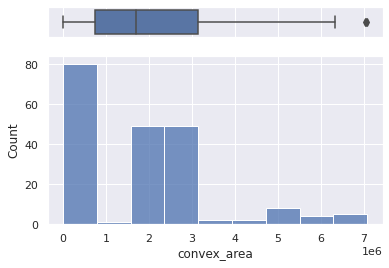

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


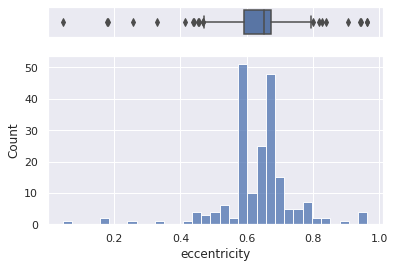

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


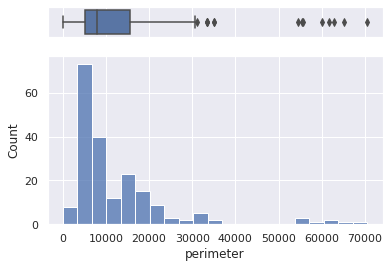

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


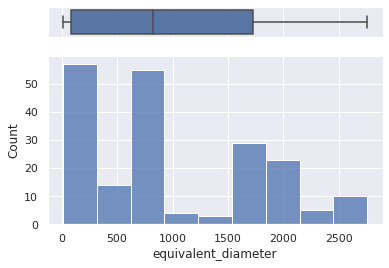

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


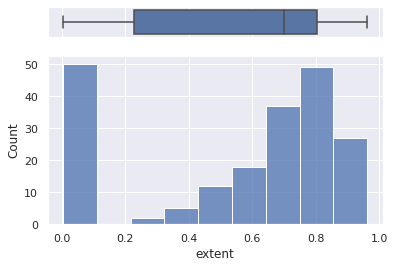

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


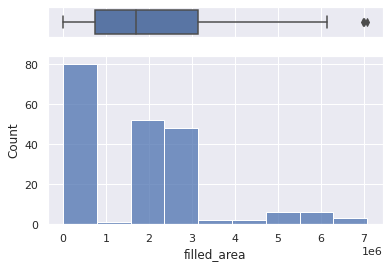

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


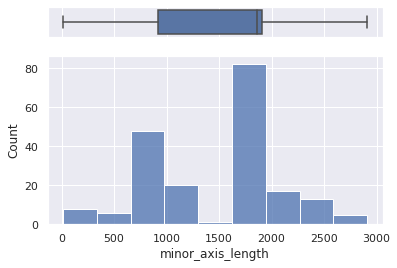

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


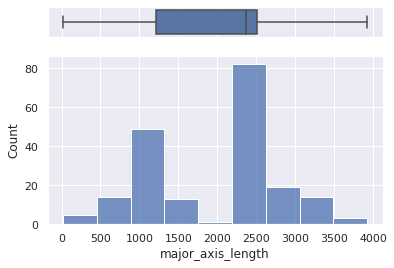

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


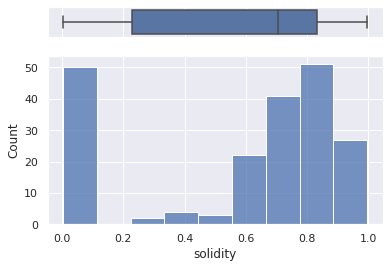

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


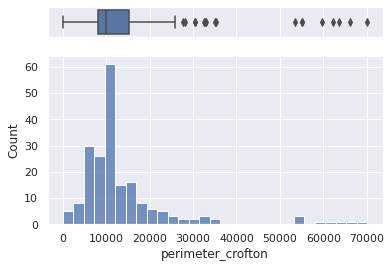

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


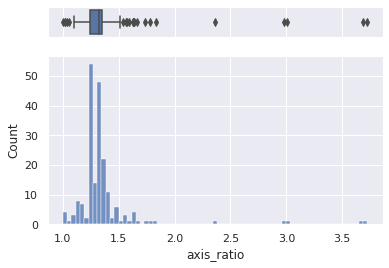

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


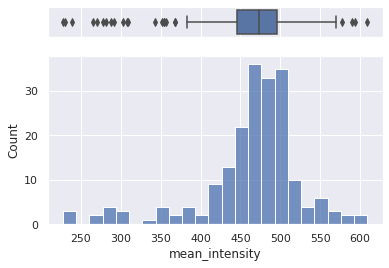

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


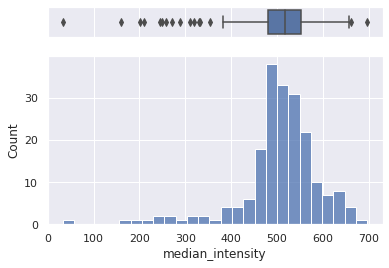

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


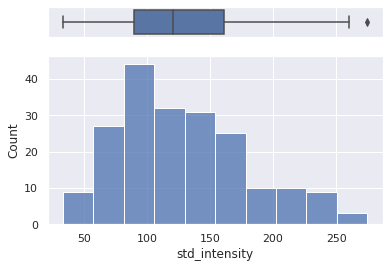

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


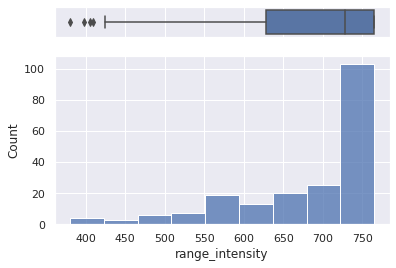

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


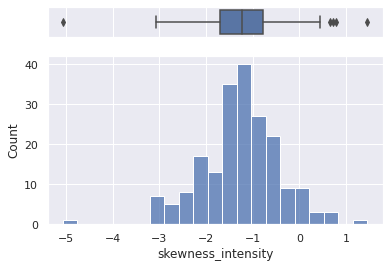

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


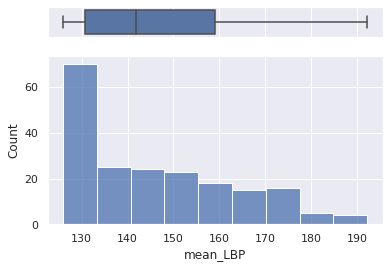

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


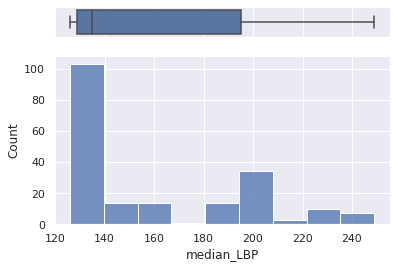

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


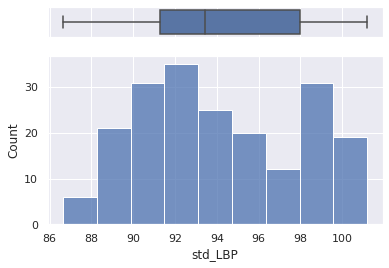

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


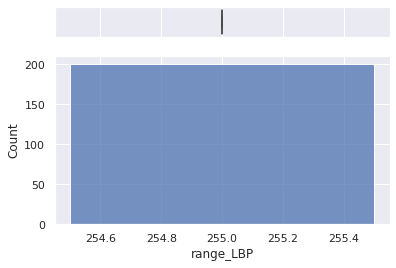

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


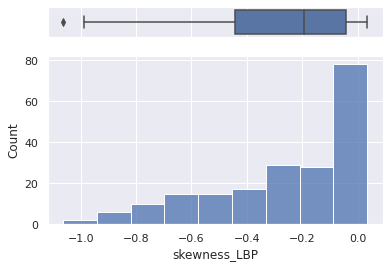

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


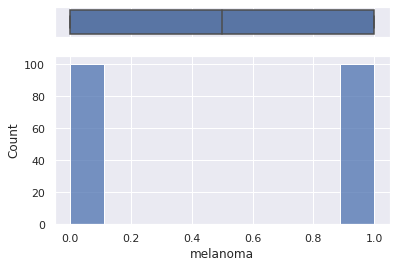

In [ ]:
dataviz(df)

In [ ]:
dfcorr= pd.concat([df[df.columns.to_list()[:21]],df[df.columns.to_list()[-1]]], axis=1)
dfcorr

,convex_area,eccentricity,perimeter,equivalent_diameter,extent,filled_area,minor_axis_length,major_axis_length,solidity,perimeter_crofton,...,median_intensity,std_intensity,range_intensity,skewness_intensity,mean_LBP,median_LBP,std_LBP,range_LBP,skewness_LBP,melanoma
1,783874.0,0.645541,7032.405517,771.794853,0.596826,783874.0,1055.918508,1382.588513,0.596826,6719.893938,...,570.0,205.741676,710.0,-0.450058,161.693328,199.0,93.250954,255.0,-0.486095,0.0
2,783874.0,0.661935,4853.898628,963.929090,0.930966,783874.0,914.960470,1220.661530,0.930966,4624.874768,...,520.0,94.613212,736.0,-2.981375,176.983055,225.0,90.499595,255.0,-0.760516,0.0
3,783874.0,0.651284,9041.543828,824.258391,0.680723,783874.0,944.237221,1244.326425,0.680723,10213.456684,...,532.0,135.199513,765.0,-1.088652,148.104713,159.0,91.008436,255.0,-0.304078,1.0
4,783874.0,0.694617,6419.728281,829.815287,0.689932,783874.0,986.984584,1371.994688,0.689932,6141.849985,...,642.0,177.379489,684.0,-0.937232,173.261851,224.0,92.148967,255.0,-0.679517,0.0
5,783874.0,0.592150,3574.000000,67.457825,0.004559,783874.0,1294.728455,1606.706640,0.004559,6774.507500,...,33.0,260.446445,765.0,0.435039,188.509735,247.0,88.840441,255.0,-0.987291,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,737038.0,0.536120,9428.789606,737.071748,0.578921,737038.0,1072.264207,1270.242043,0.578921,9126.238593,...,480.0,96.429568,569.0,-0.411697,136.721450,129.0,93.490633,255.0,-0.108192,1.0
197,736728.0,0.497688,7668.337588,871.617947,0.809566,596872.0,993.188675,1145.075782,0.809907,7370.052997,...,568.0,73.902781,614.0,-1.710215,136.587275,131.0,93.429201,255.0,-0.105371,1.0
198,737038.0,0.523960,11806.163236,818.287315,0.713529,733716.0,1022.269398,1200.208765,0.713529,11412.005136,...,635.0,103.909528,686.0,-1.226446,139.196374,135.0,96.879026,255.0,-0.150514,1.0
199,737038.0,0.468411,8782.946894,875.006207,0.815872,736207.0,1008.852994,1141.868489,0.815872,8491.731680,...,411.0,69.577553,398.0,-1.526342,136.508788,131.0,94.263710,255.0,-0.109804,1.0


In [ ]:
dfcorr.corr() #computing the correlation matrix of the different variables

,convex_area,eccentricity,perimeter,equivalent_diameter,extent,filled_area,minor_axis_length,major_axis_length,solidity,perimeter_crofton,...,median_intensity,std_intensity,range_intensity,skewness_intensity,mean_LBP,median_LBP,std_LBP,range_LBP,skewness_LBP,melanoma
convex_area,1.000000,0.010063,0.744955,0.789757,0.207286,0.991417,0.858938,0.881846,0.186186,0.751195,...,0.151859,-0.255316,-0.249919,-0.280362,-0.214738,-0.220088,0.280310,NaN,0.220364,-0.096069
eccentricity,0.010063,1.000000,0.017201,0.089395,0.108637,-0.004762,-0.161809,0.006008,0.111734,-0.030504,...,0.157844,-0.147894,-0.039222,0.069150,-0.344167,-0.334111,0.250107,NaN,0.337376,0.036237
perimeter,0.744955,0.017201,1.000000,0.720599,0.339136,0.710510,0.506903,0.534217,0.344826,0.985241,...,0.053361,-0.313356,-0.395111,-0.015035,-0.300345,-0.318244,0.334621,NaN,0.306197,0.133737
equivalent_diameter,0.789757,0.089395,0.720599,1.000000,0.743797,0.778942,0.449219,0.510934,0.723511,0.629395,...,0.112462,-0.230345,-0.464414,-0.220277,-0.513156,-0.521988,0.523358,NaN,0.504068,-0.014652
extent,0.207286,0.108637,0.339136,0.743797,1.000000,0.208790,-0.207883,-0.153176,0.988418,0.188132,...,0.044433,-0.149992,-0.504185,-0.121624,-0.557538,-0.563123,0.498261,NaN,0.540402,0.102034
filled_area,0.991417,-0.004762,0.710510,0.778942,0.208790,1.000000,0.864877,0.880357,0.180742,0.718066,...,0.156453,-0.247253,-0.239592,-0.305249,-0.205405,-0.203800,0.276151,NaN,0.209803,-0.124187
minor_axis_length,0.858938,-0.161809,0.506903,0.449219,-0.207883,0.864877,1.000000,0.972677,-0.254197,0.582812,...,0.249996,-0.167647,-0.001633,-0.351091,0.066219,0.064702,0.005431,NaN,-0.055512,-0.247767
major_axis_length,0.881846,0.006008,0.534217,0.510934,-0.153176,0.880357,0.972677,1.000000,-0.196169,0.594738,...,0.271814,-0.173990,-0.029314,-0.329383,-0.010157,-0.010459,0.076684,NaN,0.018818,-0.226287
solidity,0.186186,0.111734,0.344826,0.723511,0.988418,0.180742,-0.254197,-0.196169,1.000000,0.191971,...,-0.015614,-0.132169,-0.510110,-0.069632,-0.569365,-0.573920,0.526832,NaN,0.552818,0.132528
perimeter_crofton,0.751195,-0.030504,0.985241,0.629395,0.188132,0.718066,0.582812,0.594738,0.191971,1.000000,...,0.059621,-0.319989,-0.319795,-0.037819,-0.200865,-0.218853,0.245529,NaN,0.210031,0.097734


In [ ]:
corre=dfcorr.corr().iloc[-1].sort_values(ascending=False)[1:] #selecting the class row and display the values by descending order
print(corre) #printing it

skewness_intensity     0.352873
skewness_LBP           0.183861
axis_ratio             0.138142
perimeter              0.133737
solidity               0.132528
extent                 0.102034
perimeter_crofton      0.097734
std_intensity          0.084118
std_LBP                0.081533
eccentricity           0.036237
equivalent_diameter   -0.014652
convex_area           -0.096069
filled_area           -0.124187
range_intensity       -0.155158
mean_LBP              -0.174877
mean_intensity        -0.189474
median_intensity      -0.210693
median_LBP            -0.211175
major_axis_length     -0.226287
minor_axis_length     -0.247767
range_LBP                   NaN
Name: melanoma, dtype: float64


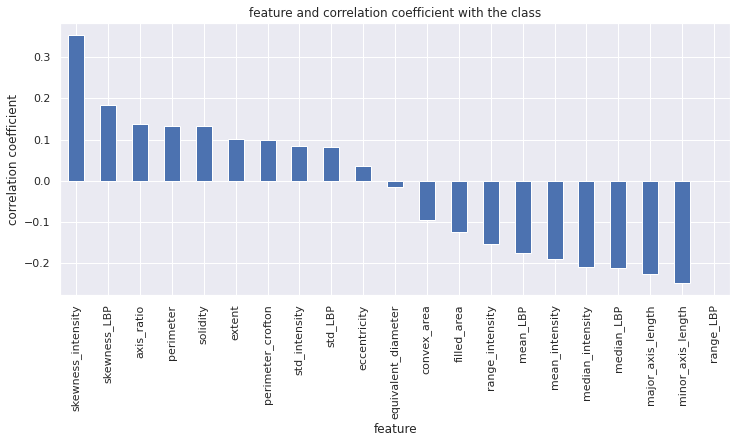

In [ ]:
plt.figure(figsize=(12, 5)) #setting the figure size
labels = [f"{i}" for i in corre.index.to_list()] #extracting the different label
ax = corre.plot(kind="bar") #ploting the different bars
ax.set_title("feature and correlation coefficient with the class") #setting the tittle
ax.set_xlabel("feature") #setting de x labels
ax.set_ylabel("correlation coefficient") #setting the y label
ax.set_xticklabels(labels) # setting the x ticks labels
plt.savefig('Feature and correlation coefficient for class',dpi=300) #saving the figure
plt.show() #showing the graph

Now we will continue by preparing the training and testing set

we can see that our target variable is highly correlated with the skewness of the intensity !

## 4 - Train/Test split

Now that we know a little more about our data and how it behaves, we can prepare the creation of a classifier based on it. We will start by separating our dataset and trying to keep the characteristics of our dataset (notably the distribution of 0 and 1 according to our target variable (melanoma). our training set and testing set will be balanced 50/50). We will make a training and testing set size with a ratio of 80/20 percent.

Standardisation of the data : 

In order to avoid any additional bias in our data, we will proceed to a standardisation of our dataset since we have to deal with flat vectors i created a function to process that

In [ ]:
df[df.columns.to_list()[-2:]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image_id  200 non-null    object 
 1   melanoma  200 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.7+ KB


In [ ]:
dfexp=df.copy()
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
dfexp=dfexp.drop(columns=['image_id'])
df_standardized = scaler.fit_transform(dfexp)


In [ ]:
dfexp=df_standardized

In [ ]:
yexp=dfexp[:, -1] #selecting the target variables
xexp=dfexp[:, :-1] #selecting the features only
# Split dataset into training set and test set

X_train,X_test,y_train,y_test= train_test_split(xexp,yexp,test_size=0.2, random_state=42, shuffle=True, stratify=df['melanoma']) #splitting into different values in order to go quicker in the computation selecting only 20% of the data

print(y_test)

print(X_train.shape,y_train.shape) #printing training data 
print(X_test.shape,y_test.shape) #printing testing data


[0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1.
 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(160, 277) (160,)
(40, 277) (40,)


In [ ]:
X_train

array([[2.39886184e-01, 5.95122615e-01, 7.36701122e-02, 2.54044729e-02,
        0.00000000e+00, 2.39891876e-01, 6.53415915e-01, 6.00710106e-01,
        0.00000000e+00, 1.41371739e-01, 8.79838027e-02, 5.02950648e-01,
        6.34036145e-01, 3.11929906e-01, 1.00000000e+00, 4.57146288e-01,
        7.19053810e-01, 6.66666667e-01, 2.83475854e-01, 0.00000000e+00,
        3.21813044e-01, 1.70392027e-02, 1.46802361e-01, 2.83222105e-03,
        4.49087340e-02, 1.06714227e-01, 3.10997890e-02, 3.61832675e-02,
        7.16872174e-01, 3.07204759e-03, 1.78625631e-02, 3.68181076e-03,
        6.34588522e-03, 4.27384008e-02, 1.79844401e-02, 3.33294164e-02,
        6.02649336e-02, 1.40962694e-01, 6.03791935e-01, 1.86645753e-02,
        3.91585416e-02, 4.90750347e-02, 2.79144242e-02, 4.23892770e-02,
        2.27248059e-01, 3.48905882e-02, 4.79997572e-02, 5.59905000e-03,
        1.94992086e-02, 7.57170471e-01, 1.56559049e-01, 1.31833548e-01,
        7.65620912e-01, 3.54422362e-03, 1.78536879e-02, 1.557971

Now that we have our data preprocessed for training and testing, let's create the different models and feed them with our Dataset !

## 6 - Training phase and modelisation

Since we have our dataset ready to fuel the training we will now focus on different algorithms in order to provide a suitable solution for our problem. We will use these 4 algorithms 



*   Decision Tree
*   ANN
*   K-N-N
*   SVM







We will apply to the different algorithms this function for computing their metrics :

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [ ]:
def model_evaluation(y_test,y_pred,nom):
    confmat=confusion_matrix(y_test, y_pred)
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, y_pred)
    # precision tp / (tp + fp)
    precision = precision_score(y_test, y_pred)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, y_pred)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    pd.DataFrame(list(zip(y_test, y_pred)), columns=['Actual', 'Predicted']) #creating a dataframe containing all the predictions
    dictcompare={'Model':nom,'Accuracy' : accuracy,'Recall':recall,'Precision':precision,'F1-score':f1,'AUC':auc,"Confusion matrix" : confmat}
    return dictcompare

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import tree
from sklearn.pipeline import Pipeline #module to create the pipeline to test the different hyperparameters
from sklearn.model_selection import GridSearchCV #tool in order to detect the best model by testing the different options
from sklearn.metrics import f1_score, make_scorer

Since our model is for a medical application we will use the f1 score as best metric because we would like more false negative than false positive

In [ ]:
dec_tree = tree.DecisionTreeClassifier(random_state=42) #creating the kind of model on wich we want to test the hyperparameters
pipe = Pipeline(steps=[('dec_tree', dec_tree)]) #setting up the pipeline
f1 = make_scorer(f1_score, average = 'macro') #creating a scorer on F1 in order to use it as a scoring method

criterion = ['gini', 'entropy'] #choosing the different criterions
max_depth = [i for i in range(1,8)] #choosing the depth we want to test
min_samples_leaf = [i for i in range(1,8)] #setting up the minimum sample in a leaf
min_impurity_decrease = [i/100 for i in range(0,10)] #setting up the different minimum impurity value for pruning
parameters = dict(dec_tree__criterion=criterion,dec_tree__max_depth=max_depth,dec_tree__min_samples_leaf=min_samples_leaf,dec_tree__min_impurity_decrease=min_impurity_decrease) #setting up the dictionnary with all the parameters choosen

clf_GS = GridSearchCV(pipe, parameters,scoring=f1) #using grid search on the pipe with our parameters
clf_GS.fit(X_train,y_train) #fitting all the different models of the pipeline
print('Best Criterion:', clf_GS.best_estimator_.get_params()['dec_tree__criterion']) #printing the best criterion for impurety for the best model
print('Best max_depth:', clf_GS.best_estimator_.get_params()['dec_tree__max_depth']) #printing the best depth for the best model
print('Best min_sample_leaf:', clf_GS.best_estimator_.get_params()['dec_tree__min_samples_leaf']) #printing the best min sample leaf for the best model
print('Best min_impurity decrease:', clf_GS.best_estimator_.get_params()['dec_tree__min_impurity_decrease']) #printing the best min sample leaf for the best model
print(); print(clf_GS.best_estimator_.get_params()['dec_tree']) #printing the best estimator

Best Criterion: gini
Best max_depth: 2
Best min_sample_leaf: 7
Best min_impurity decrease: 0.0

DecisionTreeClassifier(max_depth=2, min_samples_leaf=7, random_state=42)


In [ ]:
clf1 = DecisionTreeClassifier(criterion='gini',max_depth=2,min_samples_leaf=7,min_impurity_decrease=0.0,random_state=42) #creating the first classifier
clf1.fit(X_train,y_train) #fitting the first classifier
ypredtest1=clf1.predict(X_test) #predicting the testing data with the first classifier
evaldectree=model_evaluation(y_test,ypredtest1,'Decision Tree')
print(evaldectree)

{'Model': 'Decision Tree', 'Accuracy': 0.75, 'Recall': 0.5, 'Precision': 1.0, 'F1-score': 0.6666666666666666, 'AUC': 0.75, 'Confusion matrix': array([[20,  0],
       [10, 10]])}


### Neural Network 

In [ ]:
import tensorflow as tf 
tf.random.set_seed(42) #creating a seed in order to generate similar results in the future

def modeltosearch(nlayer1,nlayer2,bsize,epochsval,act1,act2,act3): #creating a function that create keras model easily
  ann = tf.keras.models.Sequential() #Initializing the ANN, creating the model under tensorflow
  ann.add(tf.keras.layers.Dense(units=nlayer1, activation=act1, input_shape=X_train[1].shape)) # Add the input layer and first hidden layer
  ann.add(tf.keras.layers.Dense(units=nlayer2, activation=act2))  # Add the second hidden layer
  ann.add(tf.keras.layers.Dense(units=1, activation=act3)) # Add the output layer
  ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) #compiling optimization options and parameters of the model
  ann.fit(X_train, y_train, batch_size = bsize, epochs = epochsval) #fitting the model


  y_pred = ann.predict(X_test) #making the prediction
  y_pred = (y_pred > 0.5) #getting the prediction values for the classification
  # predict probabilities for test set
  y_probs = ann.predict(X_test, verbose=0)# predict crisp classes for test set
  y_classes = y_pred
  # reduce to 1d array
  y_probs = y_probs[:, 0]
  y_pred = y_pred[:, 0]

  confmat=confusion_matrix(y_test, y_classes)
  # accuracy: (tp + tn) / (p + n)
  accuracy = accuracy_score(y_test, y_classes)
  # precision tp / (tp + fp)
  precision = precision_score(y_test, y_classes)
  # recall: tp / (tp + fn)
  recall = recall_score(y_test, y_classes)
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(y_test, y_classes)
  auc = roc_auc_score(y_test, y_probs)

  pd.DataFrame(list(zip(y_test, y_pred)), columns=['Actual', 'Predicted']) #creating a dataframe containing all the predictions
  acc=accuracy_score(y_test, y_pred) #computing accuracy
  param=[nlayer1,nlayer2,bsize,epochsval,act1,act2,act3] #getting the parameters of the model and storing it in a variable

  dictcompare={'Model':'ANN','Accuracy' : accuracy,'Recall':recall,'Precision':precision,'F1-score':f1,'AUC':auc,"Confusion matrix" : confmat}

  return param, acc,ann,dictcompare

def personnalgridsearch(varnlayer1,varnlayer2,varbsize,varepochsval,varact1,varact2,varact3):
  param=[] #intializing list containing infos about models
  accuracies=[] #intializing list containing accuracies to compare
  #looping all the parameter

  for k in range(0,len(varnlayer1)):
    for p in range(0,len(varnlayer2)):
      for m in range(0,len(varbsize)):
        for g in range(0,len(varepochsval)):
          for o in range(0,len(varact1)):
            for i in range(0,len(varact2)):
              for t in range(0,len(varact3)):
                val=modeltosearch(varnlayer1[k],varnlayer2[p],varbsize[m],varepochsval[g],varact1[o],varact2[i],varact3[t])
                param.append(val[0]) #storing infos
                accuracies.append(val[1]) #storing accuracies
  gridsearch={'param': param, 'accuracy': accuracies}
  dfsearch=pd.DataFrame(data=gridsearch)
  return dfsearch



In [ ]:
#GRid=personnalgridsearch([i for i in range(1,30,10)],[i for i in range(1,30,10)],[i for i in range(1,30,10)],[i for i in range(1,20,10)],['relu','sigmoid'],['relu','sigmoid'],['relu','sigmoid'])

2/2 [==============================] - 0s 5ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 7ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 5ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 8ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 5ms/step
Epoch 1/11
160/160 [==============================] - 1s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 2/11
160/160 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 3/11
160/160 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 4/11
160/160 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 5/11
160/160 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 6/11
160/160 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 7/11
160/160 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 8/11
160/160 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 9/11
160/160 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 10/11
160/160 [============================

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 1s 2ms/step - loss: 0.6934 - accuracy: 0.4938
Epoch 2/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 3/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.4563
Epoch 4/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.4437
Epoch 5/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.4563
Epoch 6/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6934 - accuracy: 0.4187
Epoch 7/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.4625
Epoch 8/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6934 - accuracy: 0.4313
Epoch 9/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.4688
Epoch 10/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6935 - accuracy: 0.4313
Epoch 11/1

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 1s 2ms/step - loss: 0.7278 - accuracy: 0.5000
Epoch 2/11
160/160 [==============================] - 0s 2ms/step - loss: 0.7195 - accuracy: 0.5000
Epoch 3/11
160/160 [==============================] - 0s 2ms/step - loss: 0.7135 - accuracy: 0.5000
Epoch 4/11
160/160 [==============================] - 0s 2ms/step - loss: 0.7089 - accuracy: 0.5000
Epoch 5/11
160/160 [==============================] - 0s 2ms/step - loss: 0.7054 - accuracy: 0.5000
Epoch 6/11
160/160 [==============================] - 0s 2ms/step - loss: 0.7027 - accuracy: 0.5000
Epoch 7/11
160/160 [==============================] - 0s 2ms/step - loss: 0.7005 - accuracy: 0.5000
Epoch 8/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6990 - accuracy: 0.5000
Epoch 9/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6976 - accuracy: 0.5000
Epoch 10/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6969 - accuracy: 0.5000
Epoch 11/1

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 1s 2ms/step - loss: 0.6934 - accuracy: 0.4938
Epoch 2/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 3/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.4563
Epoch 4/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.4437
Epoch 5/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.4563
Epoch 6/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6934 - accuracy: 0.4187
Epoch 7/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.4625
Epoch 8/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6934 - accuracy: 0.4313
Epoch 9/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.4688
Epoch 10/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6935 - accuracy: 0.4313
Epoch 11/1

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 8ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 5ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 6ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 7ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 6ms/step
Epoch 1/11
15/15 [==============================] - 1s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 2/11
15/15 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 3/11
15/15 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 4/11
15/15 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 5/11
15/15 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 6/11
15/15 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 7/11
15/15 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 8/11
15/15 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 9/11
15/15 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 10/11
15/15 [==============================] - 0s 2ms/step - 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 1s 2ms/step - loss: 0.6932 - accuracy: 0.4688
Epoch 2/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 3/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 4/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 5/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 6/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 7/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 8/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 9/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 10/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 11/11
2/2 [=============

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 1s 2ms/step - loss: 0.7011 - accuracy: 0.5000
Epoch 2/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6992 - accuracy: 0.5000
Epoch 3/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6973 - accuracy: 0.5000
Epoch 4/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6954 - accuracy: 0.5000
Epoch 5/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6938 - accuracy: 0.5000
Epoch 6/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6922 - accuracy: 0.5000
Epoch 7/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6911 - accuracy: 0.5000
Epoch 8/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6902 - accuracy: 0.5000
Epoch 9/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6890 - accuracy: 0.5000
Epoch 10/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6885 - accuracy: 0.5000
Epoch 11/11
2/2 [=============

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 1s 2ms/step - loss: 0.6932 - accuracy: 0.4688
Epoch 2/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 3/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 4/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 5/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 6/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 7/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 8/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 9/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 10/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 11/11
2/2 [=============

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 1s 3ms/step - loss: 0.7033 - accuracy: 0.5000
Epoch 2/11
15/15 [==============================] - 0s 2ms/step - loss: 0.7016 - accuracy: 0.5000
Epoch 3/11
15/15 [==============================] - 0s 2ms/step - loss: 0.7003 - accuracy: 0.5000
Epoch 4/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6994 - accuracy: 0.5000
Epoch 5/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6987 - accuracy: 0.5000
Epoch 6/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6980 - accuracy: 0.5000
Epoch 7/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6974 - accuracy: 0.5000
Epoch 8/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6969 - accuracy: 0.5000
Epoch 9/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6964 - accuracy: 0.5000
Epoch 10/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6960 - accuracy: 0.5000
Epoch 11/11
2/2 [=============

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 7ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 5ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 5ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 6ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 5ms/step
Epoch 1/11


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 2/11
8/8 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 3/11
8/8 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 4/11
8/8 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 5/11
8/8 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 6/11
8/8 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 7/11
8/8 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 8/11
8/8 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 9/11
8/8 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 10/11
8/8 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 11/11
2/2 [==============================] -

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 3ms/step - loss: 0.6932 - accuracy: 0.4688
Epoch 2/11
8/8 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 3/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 4/11
8/8 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 5/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 6/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 7/11
8/8 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 8/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 9/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 10/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 11/11
2/2 [==============================] -

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 3ms/step - loss: 0.7035 - accuracy: 0.5000
Epoch 2/11
8/8 [==============================] - 0s 2ms/step - loss: 0.7018 - accuracy: 0.5000
Epoch 3/11
8/8 [==============================] - 0s 2ms/step - loss: 0.6989 - accuracy: 0.5000
Epoch 4/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6967 - accuracy: 0.5000
Epoch 5/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6945 - accuracy: 0.5000
Epoch 6/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6924 - accuracy: 0.5000
Epoch 7/11
8/8 [==============================] - 0s 2ms/step - loss: 0.6910 - accuracy: 0.5000
Epoch 8/11
8/8 [==============================] - 0s 2ms/step - loss: 0.6896 - accuracy: 0.5000
Epoch 9/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6885 - accuracy: 0.5000
Epoch 10/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6878 - accuracy: 0.5063
Epoch 11/11
2/2 [==============================] -

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 3ms/step - loss: 0.6996 - accuracy: 0.5000
Epoch 2/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6982 - accuracy: 0.5000
Epoch 3/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6965 - accuracy: 0.5000
Epoch 4/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6954 - accuracy: 0.5000
Epoch 5/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6947 - accuracy: 0.5000
Epoch 6/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6941 - accuracy: 0.5000
Epoch 7/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6937 - accuracy: 0.5000
Epoch 8/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6935 - accuracy: 0.5000
Epoch 9/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 10/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.5000
Epoch 11/11
2/2 [==============================] -

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 4ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 4ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 6ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 7ms/step
Epoch 1/11


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 1s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 2/11
160/160 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 3/11
160/160 [==============================] - 1s 4ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 4/11
160/160 [==============================] - 1s 5ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 5/11
160/160 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 6/11
160/160 [==============================] - 2s 12ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 7/11
160/160 [==============================] - 2s 11ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 8/11
160/160 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 9/11
160/160 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 10/11
160/160 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 11

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 1s 2ms/step - loss: 0.6954 - accuracy: 0.5188
Epoch 2/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6892 - accuracy: 0.5375
Epoch 3/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6828 - accuracy: 0.6062
Epoch 4/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6700 - accuracy: 0.5875
Epoch 5/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6524 - accuracy: 0.6438
Epoch 6/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6296 - accuracy: 0.6125
Epoch 7/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6045 - accuracy: 0.6687
Epoch 8/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5845 - accuracy: 0.7188
Epoch 9/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5655 - accuracy: 0.7250
Epoch 10/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5438 - accuracy: 0.7688
Epoch 11/1

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 1s 2ms/step - loss: 0.7087 - accuracy: 0.5000
Epoch 2/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6906 - accuracy: 0.5000
Epoch 3/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6800 - accuracy: 0.5500
Epoch 4/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6659 - accuracy: 0.6562
Epoch 5/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6474 - accuracy: 0.7188
Epoch 6/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6299 - accuracy: 0.7563
Epoch 7/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6108 - accuracy: 0.7437
Epoch 8/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5943 - accuracy: 0.7625
Epoch 9/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5762 - accuracy: 0.7812
Epoch 10/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5597 - accuracy: 0.8000
Epoch 11/1

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 1s 2ms/step - loss: 0.6961 - accuracy: 0.5000
Epoch 2/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6922 - accuracy: 0.5000
Epoch 3/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6907 - accuracy: 0.5000
Epoch 4/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6879 - accuracy: 0.5063
Epoch 5/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6845 - accuracy: 0.5500
Epoch 6/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6791 - accuracy: 0.5125
Epoch 7/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6716 - accuracy: 0.5938
Epoch 8/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6617 - accuracy: 0.6250
Epoch 9/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6489 - accuracy: 0.6562
Epoch 10/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6319 - accuracy: 0.7063
Epoch 11/1

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 7ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 4ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 5ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 5ms/step
Epoch 1/11
15/15 [==============================] - 1s 3ms/step - loss: 1.8025 - accuracy: 0.5063
Epoch 2/11
15/15 [==============================] - 0s 2ms/step - loss: 1.1268 - accuracy: 0.4812
Epoch 3/11
15/15 [==============================] - 0s 2ms/step - loss: 0.9301 - accuracy: 0.4938
Epoch 4/11
15/15 [==============================] - 0s 2ms/step - loss: 0.7398 - accuracy: 0.4812
Epoch 5/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6770 - accuracy: 0.5125
Epoch 6/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6482 - accuracy: 0.5562
Epoch 7/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6288 - accuracy: 0.5938
Epoch 8/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6140 - accuracy: 0.6625
Epoch 9/11
15/15 [==============================] - 0s 3ms/step - loss: 0.5984 - accuracy: 0.6812
Epoch 10/11
15/15 [==============================] - 0s 2ms/step - 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 1s 2ms/step - loss: 0.6948 - accuracy: 0.5000
Epoch 2/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6938 - accuracy: 0.5000
Epoch 3/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6928 - accuracy: 0.5000
Epoch 4/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6920 - accuracy: 0.5000
Epoch 5/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6914 - accuracy: 0.5000
Epoch 6/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6905 - accuracy: 0.5000
Epoch 7/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6898 - accuracy: 0.5000
Epoch 8/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6891 - accuracy: 0.5000
Epoch 9/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6882 - accuracy: 0.5000
Epoch 10/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6876 - accuracy: 0.5000
Epoch 11/11
2/2 [=============

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 5ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 6ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 7ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 9ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 5ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 7ms/step
Epoch 1/11


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 2/11
8/8 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 3/11
8/8 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 4/11
8/8 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 5/11
8/8 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 6/11
8/8 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 7/11
8/8 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 8/11
8/8 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 9/11
8/8 [==============================] - 0s 4ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 10/11
8/8 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 11/11
2/2 [==============================] -

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 3ms/step - loss: 0.6932 - accuracy: 0.4688
Epoch 2/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 3/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 4/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 5/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 6/11
8/8 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 7/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 8/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 9/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 10/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 11/11
2/2 [==============================] -

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 3ms/step - loss: 0.7490 - accuracy: 0.5000
Epoch 2/11
8/8 [==============================] - 0s 3ms/step - loss: 0.7336 - accuracy: 0.5000
Epoch 3/11
8/8 [==============================] - 0s 3ms/step - loss: 0.7229 - accuracy: 0.5000
Epoch 4/11
8/8 [==============================] - 0s 3ms/step - loss: 0.7137 - accuracy: 0.5000
Epoch 5/11
8/8 [==============================] - 0s 3ms/step - loss: 0.7065 - accuracy: 0.5000
Epoch 6/11
8/8 [==============================] - 0s 3ms/step - loss: 0.7011 - accuracy: 0.5000
Epoch 7/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6971 - accuracy: 0.5000
Epoch 8/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5000
Epoch 9/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6890 - accuracy: 0.5000
Epoch 10/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6852 - accuracy: 0.5125
Epoch 11/11
2/2 [==============================] -

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 3ms/step - loss: 0.7092 - accuracy: 0.5000
Epoch 2/11
8/8 [==============================] - 0s 3ms/step - loss: 0.7032 - accuracy: 0.5000
Epoch 3/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6972 - accuracy: 0.5000
Epoch 4/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6939 - accuracy: 0.5000
Epoch 5/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6917 - accuracy: 0.5000
Epoch 6/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6902 - accuracy: 0.5375
Epoch 7/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6891 - accuracy: 0.5500
Epoch 8/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6886 - accuracy: 0.5000
Epoch 9/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6880 - accuracy: 0.4812
Epoch 10/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6877 - accuracy: 0.4688
Epoch 11/11
2/2 [==============================] -

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 3ms/step - loss: 0.7268 - accuracy: 0.5000
Epoch 2/11
8/8 [==============================] - 0s 3ms/step - loss: 0.7186 - accuracy: 0.5000
Epoch 3/11
8/8 [==============================] - 0s 3ms/step - loss: 0.7114 - accuracy: 0.5000
Epoch 4/11
8/8 [==============================] - 0s 2ms/step - loss: 0.7064 - accuracy: 0.5000
Epoch 5/11
8/8 [==============================] - 0s 3ms/step - loss: 0.7028 - accuracy: 0.5000
Epoch 6/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6998 - accuracy: 0.5000
Epoch 7/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6975 - accuracy: 0.5000
Epoch 8/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6960 - accuracy: 0.5000
Epoch 9/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6947 - accuracy: 0.5000
Epoch 10/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6937 - accuracy: 0.5000
Epoch 11/11
2/2 [==============================] -

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 5ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 9ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 5ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 5ms/step
Epoch 1/11
160/160 [==============================] - 1s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 2/11
160/160 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 3/11
160/160 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 4/11
160/160 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 5/11
160/160 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 6/11
160/160 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 7/11
160/160 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 8/11
160/160 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 9/11
160/160 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 10/11
160/160 [============================

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 1s 2ms/step - loss: 0.7049 - accuracy: 0.5188
Epoch 2/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6769 - accuracy: 0.5750
Epoch 3/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6646 - accuracy: 0.5938
Epoch 4/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6425 - accuracy: 0.6250
Epoch 5/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6236 - accuracy: 0.6500
Epoch 6/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6048 - accuracy: 0.7250
Epoch 7/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5804 - accuracy: 0.7188
Epoch 8/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5594 - accuracy: 0.7437
Epoch 9/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5323 - accuracy: 0.7500
Epoch 10/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5044 - accuracy: 0.7812
Epoch 11/1

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 1s 2ms/step - loss: 0.7039 - accuracy: 0.5000
Epoch 2/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6948 - accuracy: 0.5000
Epoch 3/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6953 - accuracy: 0.4563
Epoch 4/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6956 - accuracy: 0.4062
Epoch 5/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6956 - accuracy: 0.4688
Epoch 6/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6961 - accuracy: 0.4375
Epoch 7/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6955 - accuracy: 0.4125
Epoch 8/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6962 - accuracy: 0.4812
Epoch 9/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6950 - accuracy: 0.4500
Epoch 10/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6961 - accuracy: 0.5000
Epoch 11/1

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 1s 2ms/step - loss: 0.7211 - accuracy: 0.4500
Epoch 2/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6753 - accuracy: 0.5813
Epoch 3/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6683 - accuracy: 0.5750
Epoch 4/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6454 - accuracy: 0.6812
Epoch 5/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6161 - accuracy: 0.7188
Epoch 6/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5948 - accuracy: 0.7437
Epoch 7/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5686 - accuracy: 0.7437
Epoch 8/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5444 - accuracy: 0.7437
Epoch 9/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5248 - accuracy: 0.7312
Epoch 10/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5038 - accuracy: 0.7812
Epoch 11/1

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 4ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 5ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 5ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 5ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 7ms/step
Epoch 1/11
15/15 [==============================] - 1s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 2/11
15/15 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 3/11
15/15 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 4/11
15/15 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 5/11
15/15 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 6/11
15/15 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 7/11
15/15 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 8/11
15/15 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 9/11
15/15 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 10/11
15/15 [==============================] - 0s 4ms/step - 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 1s 2ms/step - loss: 0.6934 - accuracy: 0.4250
Epoch 2/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4875
Epoch 3/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4750
Epoch 4/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.5000
Epoch 5/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.5500
Epoch 6/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6924 - accuracy: 0.6000
Epoch 7/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6923 - accuracy: 0.5375
Epoch 8/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6913 - accuracy: 0.6313
Epoch 9/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6888 - accuracy: 0.6125
Epoch 10/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6845 - accuracy: 0.5938
Epoch 11/11
2/2 [=============

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 1s 2ms/step - loss: 0.7369 - accuracy: 0.5000
Epoch 2/11
15/15 [==============================] - 0s 2ms/step - loss: 0.7185 - accuracy: 0.5000
Epoch 3/11
15/15 [==============================] - 0s 3ms/step - loss: 0.7069 - accuracy: 0.5000
Epoch 4/11
15/15 [==============================] - 0s 2ms/step - loss: 0.7001 - accuracy: 0.5000
Epoch 5/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6969 - accuracy: 0.5000
Epoch 6/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6949 - accuracy: 0.5000
Epoch 7/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6939 - accuracy: 0.5000
Epoch 8/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6938 - accuracy: 0.5000
Epoch 9/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.5000
Epoch 10/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6942 - accuracy: 0.5000
Epoch 11/11
2/2 [=============

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 1s 2ms/step - loss: 1.6649 - accuracy: 0.5000
Epoch 2/11
15/15 [==============================] - 0s 3ms/step - loss: 1.1761 - accuracy: 0.5000
Epoch 3/11
15/15 [==============================] - 0s 3ms/step - loss: 1.0144 - accuracy: 0.5000
Epoch 4/11
15/15 [==============================] - 0s 2ms/step - loss: 0.9274 - accuracy: 0.5000
Epoch 5/11
15/15 [==============================] - 0s 3ms/step - loss: 0.8704 - accuracy: 0.5000
Epoch 6/11
15/15 [==============================] - 0s 2ms/step - loss: 0.8284 - accuracy: 0.5000
Epoch 7/11
15/15 [==============================] - 0s 2ms/step - loss: 0.7959 - accuracy: 0.5000
Epoch 8/11
15/15 [==============================] - 0s 3ms/step - loss: 0.7712 - accuracy: 0.5000
Epoch 9/11
15/15 [==============================] - 0s 3ms/step - loss: 0.7517 - accuracy: 0.5000
Epoch 10/11
15/15 [==============================] - 0s 3ms/step - loss: 0.7349 - accuracy: 0.5000
Epoch 11/11
2/2 [=============

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 1s 2ms/step - loss: 0.6941 - accuracy: 0.5000
Epoch 2/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 3/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6927 - accuracy: 0.5625
Epoch 4/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6924 - accuracy: 0.5562
Epoch 5/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6922 - accuracy: 0.4812
Epoch 6/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6919 - accuracy: 0.4750
Epoch 7/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6916 - accuracy: 0.4812
Epoch 8/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6914 - accuracy: 0.4812
Epoch 9/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6908 - accuracy: 0.4875
Epoch 10/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6908 - accuracy: 0.5688
Epoch 11/11
2/2 [=============

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 11ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 7ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 5ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 6ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 11ms/step
Epoch 1/11


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 2/11
8/8 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 3/11
8/8 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 4/11
8/8 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 5/11
8/8 [==============================] - 1s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 6/11
8/8 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 7/11
8/8 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 8/11
8/8 [==============================] - 0s 4ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 9/11
8/8 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 10/11
8/8 [==============================] - 0s 4ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 11/11
2/2 [==============================] -

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 3ms/step - loss: 0.6932 - accuracy: 0.4688
Epoch 2/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 3/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 4/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.4938
Epoch 5/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.4938
Epoch 6/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4938
Epoch 7/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 8/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4938
Epoch 9/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 10/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5188
Epoch 11/11
2/2 [==============================] -

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 3ms/step - loss: 0.8283 - accuracy: 0.5000
Epoch 2/11
8/8 [==============================] - 0s 4ms/step - loss: 0.7348 - accuracy: 0.5000
Epoch 3/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6923 - accuracy: 0.4563
Epoch 4/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6813 - accuracy: 0.5500
Epoch 5/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6807 - accuracy: 0.6000
Epoch 6/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6803 - accuracy: 0.6125
Epoch 7/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6791 - accuracy: 0.6125
Epoch 8/11
8/8 [==============================] - 0s 5ms/step - loss: 0.6776 - accuracy: 0.6125
Epoch 9/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6763 - accuracy: 0.6000
Epoch 10/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6767 - accuracy: 0.5938
Epoch 11/11
2/2 [==============================] -

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 6ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 10ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 5ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 6ms/step
Epoch 1/11
160/160 [==============================] - 1s 2ms/step - loss: 0.8822 - accuracy: 0.4750
Epoch 2/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6750 - accuracy: 0.5562
Epoch 3/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6483 - accuracy: 0.6250
Epoch 4/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6187 - accuracy: 0.6938
Epoch 5/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5895 - accuracy: 0.7375
Epoch 6/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5742 - accuracy: 0.7063
Epoch 7/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5510 - accuracy: 0.7500
Epoch 8/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5399 - accuracy: 0.7500
Epoch 9/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5222 - accuracy: 0.7375
Epoch 10/11
160/160 [============================

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 1s 2ms/step - loss: 0.6934 - accuracy: 0.4938
Epoch 2/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 3/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.4563
Epoch 4/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.4437
Epoch 5/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.4563
Epoch 6/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6934 - accuracy: 0.4187
Epoch 7/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.4625
Epoch 8/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6934 - accuracy: 0.4313
Epoch 9/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.4688
Epoch 10/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6935 - accuracy: 0.4313
Epoch 11/1

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 1s 2ms/step - loss: 0.7420 - accuracy: 0.5000
Epoch 2/11
160/160 [==============================] - 0s 2ms/step - loss: 0.7022 - accuracy: 0.5000
Epoch 3/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6944 - accuracy: 0.5000
Epoch 4/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6894 - accuracy: 0.5000
Epoch 5/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6847 - accuracy: 0.5000
Epoch 6/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6806 - accuracy: 0.5000
Epoch 7/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6753 - accuracy: 0.5000
Epoch 8/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6702 - accuracy: 0.5000
Epoch 9/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6657 - accuracy: 0.5000
Epoch 10/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6627 - accuracy: 0.5375
Epoch 11/1

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 6ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 6ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 5ms/step
Epoch 1/11
15/15 [==============================] - 1s 3ms/step - loss: 0.7799 - accuracy: 0.5437
Epoch 2/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6723 - accuracy: 0.5688
Epoch 3/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6444 - accuracy: 0.6250
Epoch 4/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6227 - accuracy: 0.6562
Epoch 5/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6109 - accuracy: 0.6562
Epoch 6/11
15/15 [==============================] - 0s 3ms/step - loss: 0.5862 - accuracy: 0.7250
Epoch 7/11
15/15 [==============================] - 0s 3ms/step - loss: 0.5651 - accuracy: 0.7000
Epoch 8/11
15/15 [==============================] - 0s 3ms/step - loss: 0.5528 - accuracy: 0.7063
Epoch 9/11
15/15 [==============================] - 0s 2ms/step - loss: 0.5327 - accuracy: 0.7688
Epoch 10/11
15/15 [==============================] - 0s 2ms/step - 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 1s 2ms/step - loss: 0.6932 - accuracy: 0.4688
Epoch 2/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 3/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 4/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 5/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 6/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 7/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 8/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 9/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 10/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 11/11
2/2 [=============

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 6ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 5ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 10ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 6ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 7ms/step
Epoch 1/11
8/8 [==============================] - 1s 3ms/step - loss: 2.2014 - accuracy: 0.4437
Epoch 2/11
8/8 [==============================] - 0s 3ms/step - loss: 0.9443 - accuracy: 0.4688
Epoch 3/11
8/8 [==============================] - 0s 3ms/step - loss: 0.7991 - accuracy: 0.5000
Epoch 4/11
8/8 [==============================] - 0s 3ms/step - loss: 0.7026 - accuracy: 0.5188
Epoch 5/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6544 - accuracy: 0.5875
Epoch 6/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6219 - accuracy: 0.6562
Epoch 7/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6044 - accuracy: 0.6625
Epoch 8/11
8/8 [==============================] - 0s 3ms/step - loss: 0.5885 - accuracy: 0.7063
Epoch 9/11
8/8 [==============================] - 0s 3ms/step - loss: 0.5738 - accuracy: 0.7250
Epoch 10/11
8/8 [==============================] - 0s 3ms/step - loss: 0.5592 - accur

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 3ms/step - loss: 0.7376 - accuracy: 0.5000
Epoch 2/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6998 - accuracy: 0.5000
Epoch 3/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6862 - accuracy: 0.5000
Epoch 4/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6821 - accuracy: 0.5000
Epoch 5/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5063
Epoch 6/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6781 - accuracy: 0.5688
Epoch 7/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6764 - accuracy: 0.5938
Epoch 8/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6749 - accuracy: 0.5188
Epoch 9/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6735 - accuracy: 0.5125
Epoch 10/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6727 - accuracy: 0.5000
Epoch 11/11
2/2 [==============================] -

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 3ms/step - loss: 0.6932 - accuracy: 0.4688
Epoch 2/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 3/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 4/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 5/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 6/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 7/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 8/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 9/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 10/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 11/11
2/2 [==============================] -

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 6ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 8ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 11ms/step
Epoch 1/11


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 1s 2ms/step - loss: 1.3563 - accuracy: 0.5000
Epoch 2/11
160/160 [==============================] - 0s 2ms/step - loss: 0.9831 - accuracy: 0.5000
Epoch 3/11
160/160 [==============================] - 0s 2ms/step - loss: 0.8275 - accuracy: 0.5188
Epoch 4/11
160/160 [==============================] - 0s 2ms/step - loss: 0.7254 - accuracy: 0.5625
Epoch 5/11
160/160 [==============================] - 0s 3ms/step - loss: 0.6828 - accuracy: 0.5125
Epoch 6/11
160/160 [==============================] - 1s 3ms/step - loss: 0.6653 - accuracy: 0.4875
Epoch 7/11
160/160 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.5250
Epoch 8/11
160/160 [==============================] - 0s 3ms/step - loss: 0.6403 - accuracy: 0.5688
Epoch 9/11
160/160 [==============================] - 0s 3ms/step - loss: 0.6253 - accuracy: 0.6187
Epoch 10/11
160/160 [==============================] - 0s 3ms/step - loss: 0.6110 - accuracy: 0.6812
Epoch 11/1

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 1s 2ms/step - loss: 0.6920 - accuracy: 0.5562
Epoch 2/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6709 - accuracy: 0.6125
Epoch 3/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6503 - accuracy: 0.6812
Epoch 4/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6268 - accuracy: 0.7000
Epoch 5/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6041 - accuracy: 0.7375
Epoch 6/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5819 - accuracy: 0.7563
Epoch 7/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5676 - accuracy: 0.7563
Epoch 8/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5462 - accuracy: 0.7812
Epoch 9/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5339 - accuracy: 0.7688
Epoch 10/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5202 - accuracy: 0.7812
Epoch 11/1

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 1s 2ms/step - loss: 0.7321 - accuracy: 0.5000
Epoch 2/11
15/15 [==============================] - 0s 2ms/step - loss: 0.7118 - accuracy: 0.5000
Epoch 3/11
15/15 [==============================] - 0s 2ms/step - loss: 0.7016 - accuracy: 0.5000
Epoch 4/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6958 - accuracy: 0.5000
Epoch 5/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.5000
Epoch 6/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6875 - accuracy: 0.5000
Epoch 7/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6841 - accuracy: 0.5000
Epoch 8/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6810 - accuracy: 0.5063
Epoch 9/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6770 - accuracy: 0.5938
Epoch 10/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6742 - accuracy: 0.6750
Epoch 11/11
2/2 [=============

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 4ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 5ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 11ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 11ms/step
Epoch 1/11


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 3ms/step - loss: 1.3856 - accuracy: 0.4688
Epoch 2/11
8/8 [==============================] - 0s 3ms/step - loss: 0.7368 - accuracy: 0.5688
Epoch 3/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6818 - accuracy: 0.6000
Epoch 4/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6530 - accuracy: 0.6375
Epoch 5/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6403 - accuracy: 0.6125
Epoch 6/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6158 - accuracy: 0.6500
Epoch 7/11
8/8 [==============================] - 0s 4ms/step - loss: 0.5976 - accuracy: 0.6750
Epoch 8/11
8/8 [==============================] - 0s 3ms/step - loss: 0.5844 - accuracy: 0.6625
Epoch 9/11
8/8 [==============================] - 0s 3ms/step - loss: 0.5653 - accuracy: 0.7125
Epoch 10/11
8/8 [==============================] - 0s 3ms/step - loss: 0.5495 - accuracy: 0.7375
Epoch 11/11
2/2 [==============================] -

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 3ms/step - loss: 0.6935 - accuracy: 0.4563
Epoch 2/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6876 - accuracy: 0.5188
Epoch 3/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6844 - accuracy: 0.5562
Epoch 4/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6814 - accuracy: 0.6125
Epoch 5/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.6250
Epoch 6/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6744 - accuracy: 0.6938
Epoch 7/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6709 - accuracy: 0.7063
Epoch 8/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6657 - accuracy: 0.6938
Epoch 9/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6590 - accuracy: 0.7063
Epoch 10/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6522 - accuracy: 0.7125
Epoch 11/11
2/2 [==============================] -

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 2s 3ms/step - loss: 0.7233 - accuracy: 0.5000
Epoch 2/11
8/8 [==============================] - 0s 3ms/step - loss: 0.7054 - accuracy: 0.5000
Epoch 3/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.5000
Epoch 4/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6881 - accuracy: 0.5500
Epoch 5/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6863 - accuracy: 0.5000
Epoch 6/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6849 - accuracy: 0.5437
Epoch 7/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6837 - accuracy: 0.5813
Epoch 8/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6828 - accuracy: 0.5938
Epoch 9/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6815 - accuracy: 0.6000
Epoch 10/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6807 - accuracy: 0.5813
Epoch 11/11
2/2 [==============================] -

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 13ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 10ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 12ms/step
Epoch 1/11
160/160 [==============================] - 1s 2ms/step - loss: 2.1830 - accuracy: 0.5063
Epoch 2/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5783 - accuracy: 0.6938
Epoch 3/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5387 - accuracy: 0.7250
Epoch 4/11
160/160 [==============================] - 0s 2ms/step - loss: 3.0656 - accuracy: 0.6000
Epoch 5/11
160/160 [==============================] - 0s 2ms/step - loss: 3.4838 - accuracy: 0.6500
Epoch 6/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6202 - accuracy: 0.6375
Epoch 7/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5238 - accuracy: 0.7563
Epoch 8/11
160/160 [==============================] - 0s 2ms/step - loss: 0.4910 - accuracy: 0.7937
Epoch 9/11
160/160 [==============================] - 0s 2ms/step - loss: 0.4626 - accuracy: 0.8000
Epoch 10/11
160/160 [===========================

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 1s 2ms/step - loss: 0.6971 - accuracy: 0.5188
Epoch 2/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6537 - accuracy: 0.6812
Epoch 3/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6280 - accuracy: 0.6812
Epoch 4/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6010 - accuracy: 0.7250
Epoch 5/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5657 - accuracy: 0.7375
Epoch 6/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5429 - accuracy: 0.7688
Epoch 7/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5255 - accuracy: 0.7812
Epoch 8/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5071 - accuracy: 0.7812
Epoch 9/11
160/160 [==============================] - 0s 2ms/step - loss: 0.4971 - accuracy: 0.7812
Epoch 10/11
160/160 [==============================] - 0s 2ms/step - loss: 0.4822 - accuracy: 0.7812
Epoch 11/1

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 1s 2ms/step - loss: 0.6969 - accuracy: 0.4812
Epoch 2/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6846 - accuracy: 0.5938
Epoch 3/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6791 - accuracy: 0.5562
Epoch 4/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6667 - accuracy: 0.6375
Epoch 5/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6454 - accuracy: 0.7125
Epoch 6/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6228 - accuracy: 0.7500
Epoch 7/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5977 - accuracy: 0.7812
Epoch 8/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5734 - accuracy: 0.7750
Epoch 9/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5529 - accuracy: 0.7688
Epoch 10/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5316 - accuracy: 0.7812
Epoch 11/1

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 5ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 5ms/step
Epoch 1/11
15/15 [==============================] - 1s 3ms/step - loss: 0.6742 - accuracy: 0.5188
Epoch 2/11
15/15 [==============================] - 0s 4ms/step - loss: 0.5513 - accuracy: 0.7312
Epoch 3/11
15/15 [==============================] - 0s 3ms/step - loss: 0.5355 - accuracy: 0.7375
Epoch 4/11
15/15 [==============================] - 0s 3ms/step - loss: 0.5114 - accuracy: 0.7812
Epoch 5/11
15/15 [==============================] - 0s 3ms/step - loss: 0.5287 - accuracy: 0.7125
Epoch 6/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6844 - accuracy: 0.7188
Epoch 7/11
15/15 [==============================] - 0s 2ms/step - loss: 0.4964 - accuracy: 0.7812
Epoch 8/11
15/15 [==============================] - 0s 2ms/step - loss: 0.4901 - accuracy: 0.7937
Epoch 9/11
15/15 [==============================] - 0s 2ms/step - loss: 0.5038 - accuracy: 0.7937
Epoch 10/11
15/15 [==============================] - 0s 3ms/step - 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 1s 2ms/step - loss: 0.7135 - accuracy: 0.5000
Epoch 2/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6927 - accuracy: 0.4812
Epoch 3/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6866 - accuracy: 0.5875
Epoch 4/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6823 - accuracy: 0.6500
Epoch 5/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6783 - accuracy: 0.6500
Epoch 6/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6708 - accuracy: 0.7312
Epoch 7/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6636 - accuracy: 0.7812
Epoch 8/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6547 - accuracy: 0.7625
Epoch 9/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.7875
Epoch 10/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6347 - accuracy: 0.7812
Epoch 11/11
2/2 [=============

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 8ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 6ms/step
Epoch 1/11
8/8 [==============================] - 1s 3ms/step - loss: 2.2005 - accuracy: 0.5000
Epoch 2/11
8/8 [==============================] - 0s 3ms/step - loss: 0.7991 - accuracy: 0.5813
Epoch 3/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6564 - accuracy: 0.6313
Epoch 4/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6169 - accuracy: 0.6750
Epoch 5/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6014 - accuracy: 0.6750
Epoch 6/11
8/8 [==============================] - 0s 4ms/step - loss: 0.5638 - accuracy: 0.7812
Epoch 7/11
8/8 [==============================] - 0s 3ms/step - loss: 0.5512 - accuracy: 0.7937
Epoch 8/11
8/8 [==============================] - 0s 3ms/step - loss: 0.5466 - accuracy: 0.7437
Epoch 9/11
8/8 [==============================] - 0s 3ms/step - loss: 0.5362 - accuracy: 0.7937
Epoch 10/11
8/8 [==============================] - 0s 3ms/step - loss: 0.5301 - accur

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 3ms/step - loss: 0.7058 - accuracy: 0.5000
Epoch 2/11
8/8 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.5000
Epoch 3/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6855 - accuracy: 0.5500
Epoch 4/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6806 - accuracy: 0.6313
Epoch 5/11
8/8 [==============================] - 0s 5ms/step - loss: 0.6758 - accuracy: 0.6687
Epoch 6/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6699 - accuracy: 0.6562
Epoch 7/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6651 - accuracy: 0.6875
Epoch 8/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6595 - accuracy: 0.6938
Epoch 9/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6750
Epoch 10/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6812
Epoch 11/11
2/2 [==============================] -

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 6ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 5ms/step
Epoch 1/11


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 1s 2ms/step - loss: 3.6732 - accuracy: 0.5875
Epoch 2/11
160/160 [==============================] - 0s 2ms/step - loss: 4.7310 - accuracy: 0.6187
Epoch 3/11
160/160 [==============================] - 0s 2ms/step - loss: 7.7126 - accuracy: 0.5000
Epoch 4/11
160/160 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 5/11
160/160 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 6/11
160/160 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 7/11
160/160 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 8/11
160/160 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 9/11
160/160 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 10/11
160/160 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 11/1

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 1s 2ms/step - loss: 0.6936 - accuracy: 0.4750
Epoch 2/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 3/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.4563
Epoch 4/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.4437
Epoch 5/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.4563
Epoch 6/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6934 - accuracy: 0.4250
Epoch 7/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.4625
Epoch 8/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6934 - accuracy: 0.4313
Epoch 9/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.4688
Epoch 10/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6935 - accuracy: 0.4313
Epoch 11/1

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 1s 2ms/step - loss: 0.6934 - accuracy: 0.4938
Epoch 2/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 3/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.4563
Epoch 4/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.4437
Epoch 5/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.4563
Epoch 6/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6934 - accuracy: 0.4187
Epoch 7/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.4625
Epoch 8/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6934 - accuracy: 0.4313
Epoch 9/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.4688
Epoch 10/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6935 - accuracy: 0.4313
Epoch 11/1

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 1s 2ms/step - loss: 0.6928 - accuracy: 0.5000
Epoch 2/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6867 - accuracy: 0.5000
Epoch 3/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6826 - accuracy: 0.5000
Epoch 4/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6785 - accuracy: 0.4875
Epoch 5/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6731 - accuracy: 0.4938
Epoch 6/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6690 - accuracy: 0.5625
Epoch 7/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6652 - accuracy: 0.5750
Epoch 8/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6610 - accuracy: 0.6250
Epoch 9/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6580 - accuracy: 0.6187
Epoch 10/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6559 - accuracy: 0.6313
Epoch 11/1

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 8ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 10ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 5ms/step
Epoch 1/11
15/15 [==============================] - 1s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 2/11
15/15 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 3/11
15/15 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 4/11
15/15 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 5/11
15/15 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 6/11
15/15 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 7/11
15/15 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 8/11
15/15 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 9/11
15/15 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 10/11
15/15 [==============================] - 0s 2ms/step - 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 1s 5ms/step - loss: 0.6910 - accuracy: 0.4938
Epoch 2/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6831 - accuracy: 0.5750
Epoch 3/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6760 - accuracy: 0.6062
Epoch 4/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6702 - accuracy: 0.5750
Epoch 5/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6644 - accuracy: 0.5750
Epoch 6/11
15/15 [==============================] - 0s 5ms/step - loss: 0.6542 - accuracy: 0.6062
Epoch 7/11
15/15 [==============================] - 0s 4ms/step - loss: 0.6443 - accuracy: 0.6000
Epoch 8/11
15/15 [==============================] - 0s 4ms/step - loss: 0.6336 - accuracy: 0.6250
Epoch 9/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6224 - accuracy: 0.6812
Epoch 10/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6119 - accuracy: 0.6875
Epoch 11/11
2/2 [=============

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 1s 2ms/step - loss: 0.7321 - accuracy: 0.5000
Epoch 2/11
15/15 [==============================] - 0s 3ms/step - loss: 0.7038 - accuracy: 0.5000
Epoch 3/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6895 - accuracy: 0.5000
Epoch 4/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6798 - accuracy: 0.5000
Epoch 5/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6722 - accuracy: 0.5000
Epoch 6/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6656 - accuracy: 0.5000
Epoch 7/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6593 - accuracy: 0.5000
Epoch 8/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6540 - accuracy: 0.5000
Epoch 9/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6493 - accuracy: 0.5000
Epoch 10/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6438 - accuracy: 0.5000
Epoch 11/11
2/2 [=============

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 1s 3ms/step - loss: 0.6933 - accuracy: 0.5000
Epoch 2/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.5000
Epoch 3/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6914 - accuracy: 0.5000
Epoch 4/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6907 - accuracy: 0.5000
Epoch 5/11
15/15 [==============================] - 0s 4ms/step - loss: 0.6901 - accuracy: 0.5000
Epoch 6/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6892 - accuracy: 0.5000
Epoch 7/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.5000
Epoch 8/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6876 - accuracy: 0.5000
Epoch 9/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6865 - accuracy: 0.5000
Epoch 10/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6856 - accuracy: 0.5000
Epoch 11/11
2/2 [=============

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 6ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 6ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 8ms/step
Epoch 1/11


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 5ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 2/11
8/8 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 3/11
8/8 [==============================] - 0s 4ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 4/11
8/8 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 5/11
8/8 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 6/11
8/8 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 7/11
8/8 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 8/11
8/8 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 9/11
8/8 [==============================] - 0s 4ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 10/11
8/8 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 11/11
2/2 [==============================] -

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 3ms/step - loss: 0.6937 - accuracy: 0.4688
Epoch 2/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 3/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 4/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 5/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 6/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 7/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 8/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 9/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 10/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 11/11
2/2 [==============================] -

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 3ms/step - loss: 0.7002 - accuracy: 0.5000
Epoch 2/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6896 - accuracy: 0.5000
Epoch 3/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.5000
Epoch 4/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6835 - accuracy: 0.5000
Epoch 5/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.5625
Epoch 6/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6800 - accuracy: 0.5750
Epoch 7/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6781 - accuracy: 0.5750
Epoch 8/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6764 - accuracy: 0.5813
Epoch 9/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6747 - accuracy: 0.5875
Epoch 10/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6731 - accuracy: 0.5875
Epoch 11/11
2/2 [==============================] -

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 3ms/step - loss: 0.6933 - accuracy: 0.4688
Epoch 2/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 3/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 4/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 5/11
8/8 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 6/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 7/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 8/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 9/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 10/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 11/11
2/2 [==============================] -

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 3ms/step - loss: 0.7093 - accuracy: 0.5000
Epoch 2/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6990 - accuracy: 0.5000
Epoch 3/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.5000
Epoch 4/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6901 - accuracy: 0.5000
Epoch 5/11
8/8 [==============================] - 0s 5ms/step - loss: 0.6888 - accuracy: 0.5000
Epoch 6/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6879 - accuracy: 0.5000
Epoch 7/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6870 - accuracy: 0.5000
Epoch 8/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6864 - accuracy: 0.5000
Epoch 9/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6856 - accuracy: 0.5000
Epoch 10/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6852 - accuracy: 0.5000
Epoch 11/11
2/2 [==============================] -

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 12ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 6ms/step
Epoch 1/11
160/160 [==============================] - 1s 2ms/step - loss: 3.6749 - accuracy: 0.6187
Epoch 2/11
160/160 [==============================] - 0s 2ms/step - loss: 3.6198 - accuracy: 0.6500
Epoch 3/11
160/160 [==============================] - 0s 2ms/step - loss: 3.6151 - accuracy: 0.6562
Epoch 4/11
160/160 [==============================] - 0s 2ms/step - loss: 3.6088 - accuracy: 0.6500
Epoch 5/11
160/160 [==============================] - 0s 2ms/step - loss: 3.5919 - accuracy: 0.6625
Epoch 6/11
160/160 [==============================] - 0s 2ms/step - loss: 3.5793 - accuracy: 0.6687
Epoch 7/11
160/160 [==============================] - 0s 2ms/step - loss: 3.5901 - accuracy: 0.6625
Epoch 8/11
160/160 [==============================] - 0s 2ms/step - loss: 3.5796 - accuracy: 0.6625
Epoch 9/11
160/160 [==============================] - 0s 2ms/step - loss: 3.5680 - accuracy: 0.6625
Epoch 10/11
160/160 [============================

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 1s 2ms/step - loss: 0.7235 - accuracy: 0.5125
Epoch 2/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6386 - accuracy: 0.6313
Epoch 3/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5951 - accuracy: 0.7125
Epoch 4/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5572 - accuracy: 0.7188
Epoch 5/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5306 - accuracy: 0.7625
Epoch 6/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5039 - accuracy: 0.7750
Epoch 7/11
160/160 [==============================] - 0s 2ms/step - loss: 0.4970 - accuracy: 0.7812
Epoch 8/11
160/160 [==============================] - 0s 2ms/step - loss: 0.4817 - accuracy: 0.7688
Epoch 9/11
160/160 [==============================] - 0s 2ms/step - loss: 0.4724 - accuracy: 0.8000
Epoch 10/11
160/160 [==============================] - 0s 2ms/step - loss: 0.4614 - accuracy: 0.7875
Epoch 11/1

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 1s 2ms/step - loss: 0.7149 - accuracy: 0.5188
Epoch 2/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6413 - accuracy: 0.6812
Epoch 3/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6117 - accuracy: 0.6812
Epoch 4/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5871 - accuracy: 0.7125
Epoch 5/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5582 - accuracy: 0.7312
Epoch 6/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5449 - accuracy: 0.7625
Epoch 7/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5282 - accuracy: 0.7688
Epoch 8/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5116 - accuracy: 0.7563
Epoch 9/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5097 - accuracy: 0.7563
Epoch 10/11
160/160 [==============================] - 0s 2ms/step - loss: 0.4918 - accuracy: 0.7688
Epoch 11/1

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 8ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 6ms/step
Epoch 1/11


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 1s 2ms/step - loss: 7.0062 - accuracy: 0.5000
Epoch 2/11
15/15 [==============================] - 0s 3ms/step - loss: 4.6641 - accuracy: 0.5000
Epoch 3/11
15/15 [==============================] - 0s 3ms/step - loss: 0.9216 - accuracy: 0.5000
Epoch 4/11
15/15 [==============================] - 0s 3ms/step - loss: 0.7472 - accuracy: 0.5125
Epoch 5/11
15/15 [==============================] - 0s 3ms/step - loss: 0.7092 - accuracy: 0.5688
Epoch 6/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6830 - accuracy: 0.5875
Epoch 7/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6563 - accuracy: 0.5938
Epoch 8/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6323 - accuracy: 0.5938
Epoch 9/11
15/15 [==============================] - 0s 4ms/step - loss: 0.6109 - accuracy: 0.6000
Epoch 10/11
15/15 [==============================] - 0s 3ms/step - loss: 0.5894 - accuracy: 0.6125
Epoch 11/11
2/2 [=============

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 1s 3ms/step - loss: 0.6963 - accuracy: 0.5000
Epoch 2/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6892 - accuracy: 0.5000
Epoch 3/11
15/15 [==============================] - 0s 4ms/step - loss: 0.6834 - accuracy: 0.5375
Epoch 4/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6786 - accuracy: 0.6562
Epoch 5/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6748 - accuracy: 0.6687
Epoch 6/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6687 - accuracy: 0.6875
Epoch 7/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6638 - accuracy: 0.6875
Epoch 8/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6586 - accuracy: 0.6812
Epoch 9/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6521 - accuracy: 0.7000
Epoch 10/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.7312
Epoch 11/11
2/2 [=============

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 12ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 5ms/step
Epoch 1/11


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 4ms/step - loss: 1.3814 - accuracy: 0.4875
Epoch 2/11
8/8 [==============================] - 0s 4ms/step - loss: 0.7221 - accuracy: 0.4812
Epoch 3/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6566 - accuracy: 0.5375
Epoch 4/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6200 - accuracy: 0.6313
Epoch 5/11
8/8 [==============================] - 0s 3ms/step - loss: 0.5875 - accuracy: 0.6812
Epoch 6/11
8/8 [==============================] - 0s 3ms/step - loss: 0.5582 - accuracy: 0.7563
Epoch 7/11
8/8 [==============================] - 0s 4ms/step - loss: 0.5154 - accuracy: 0.8000
Epoch 8/11
8/8 [==============================] - 0s 3ms/step - loss: 0.4952 - accuracy: 0.8125
Epoch 9/11
8/8 [==============================] - 0s 3ms/step - loss: 0.4758 - accuracy: 0.8125
Epoch 10/11
8/8 [==============================] - 0s 4ms/step - loss: 0.4853 - accuracy: 0.7688
Epoch 11/11
2/2 [==============================] -

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 3ms/step - loss: 0.8188 - accuracy: 0.5000
Epoch 2/11
8/8 [==============================] - 0s 4ms/step - loss: 0.7729 - accuracy: 0.5000
Epoch 3/11
8/8 [==============================] - 0s 4ms/step - loss: 0.7471 - accuracy: 0.5000
Epoch 4/11
8/8 [==============================] - 0s 5ms/step - loss: 0.7277 - accuracy: 0.5000
Epoch 5/11
8/8 [==============================] - 0s 5ms/step - loss: 0.7141 - accuracy: 0.5000
Epoch 6/11
8/8 [==============================] - 0s 4ms/step - loss: 0.7020 - accuracy: 0.5000
Epoch 7/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6919 - accuracy: 0.5063
Epoch 8/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6826 - accuracy: 0.5063
Epoch 9/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6742 - accuracy: 0.5375
Epoch 10/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6670 - accuracy: 0.5875
Epoch 11/11
2/2 [==============================] -

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 7ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 6ms/step
Epoch 1/11
160/160 [==============================] - 1s 2ms/step - loss: 3.9445 - accuracy: 0.6187
Epoch 2/11
160/160 [==============================] - 0s 2ms/step - loss: 3.4782 - accuracy: 0.6562
Epoch 3/11
160/160 [==============================] - 0s 2ms/step - loss: 3.6923 - accuracy: 0.6313
Epoch 4/11
160/160 [==============================] - 0s 2ms/step - loss: 3.6014 - accuracy: 0.6438
Epoch 5/11
160/160 [==============================] - 0s 2ms/step - loss: 3.5859 - accuracy: 0.6687
Epoch 6/11
160/160 [==============================] - 0s 2ms/step - loss: 3.5934 - accuracy: 0.6438
Epoch 7/11
160/160 [==============================] - 0s 3ms/step - loss: 3.5970 - accuracy: 0.6500
Epoch 8/11
160/160 [==============================] - 1s 3ms/step - loss: 3.5934 - accuracy: 0.6687
Epoch 9/11
160/160 [==============================] - 0s 3ms/step - loss: 3.5813 - accuracy: 0.6625
Epoch 10/11
160/160 [============================

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 1s 2ms/step - loss: 0.7160 - accuracy: 0.5063
Epoch 2/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6556 - accuracy: 0.6250
Epoch 3/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6158 - accuracy: 0.7000
Epoch 4/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5758 - accuracy: 0.6938
Epoch 5/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5418 - accuracy: 0.7437
Epoch 6/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5174 - accuracy: 0.7688
Epoch 7/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5060 - accuracy: 0.7812
Epoch 8/11
160/160 [==============================] - 0s 2ms/step - loss: 0.4889 - accuracy: 0.7750
Epoch 9/11
160/160 [==============================] - 0s 2ms/step - loss: 0.4798 - accuracy: 0.7875
Epoch 10/11
160/160 [==============================] - 0s 2ms/step - loss: 0.4696 - accuracy: 0.7875
Epoch 11/1

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 1s 2ms/step - loss: 0.7035 - accuracy: 0.5188
Epoch 2/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6774 - accuracy: 0.6062
Epoch 3/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6644 - accuracy: 0.5688
Epoch 4/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6424 - accuracy: 0.6938
Epoch 5/11
160/160 [==============================] - 0s 2ms/step - loss: 0.6152 - accuracy: 0.6938
Epoch 6/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5914 - accuracy: 0.7625
Epoch 7/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5655 - accuracy: 0.7750
Epoch 8/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5418 - accuracy: 0.7625
Epoch 9/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5278 - accuracy: 0.7563
Epoch 10/11
160/160 [==============================] - 0s 2ms/step - loss: 0.5071 - accuracy: 0.7875
Epoch 11/1

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 6ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 7ms/step
Epoch 1/11
15/15 [==============================] - 1s 2ms/step - loss: 1.0252 - accuracy: 0.4938
Epoch 2/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6334 - accuracy: 0.5750
Epoch 3/11
15/15 [==============================] - 0s 3ms/step - loss: 0.5882 - accuracy: 0.6625
Epoch 4/11
15/15 [==============================] - 0s 3ms/step - loss: 0.5431 - accuracy: 0.6875
Epoch 5/11
15/15 [==============================] - 0s 3ms/step - loss: 0.5243 - accuracy: 0.7312
Epoch 6/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6973 - accuracy: 0.7063
Epoch 7/11
15/15 [==============================] - 0s 3ms/step - loss: 0.4903 - accuracy: 0.7937
Epoch 8/11
15/15 [==============================] - 0s 3ms/step - loss: 0.4852 - accuracy: 0.7750
Epoch 9/11
15/15 [==============================] - 0s 3ms/step - loss: 0.4833 - accuracy: 0.7812
Epoch 10/11
15/15 [==============================] - 0s 3ms/step - 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 1s 3ms/step - loss: 0.6922 - accuracy: 0.5250
Epoch 2/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6780 - accuracy: 0.6125
Epoch 3/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6654 - accuracy: 0.6562
Epoch 4/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6527 - accuracy: 0.7125
Epoch 5/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6405 - accuracy: 0.7125
Epoch 6/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6203 - accuracy: 0.7312
Epoch 7/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6019 - accuracy: 0.7500
Epoch 8/11
15/15 [==============================] - 0s 3ms/step - loss: 0.5835 - accuracy: 0.7375
Epoch 9/11
15/15 [==============================] - 0s 3ms/step - loss: 0.5651 - accuracy: 0.7750
Epoch 10/11
15/15 [==============================] - 0s 3ms/step - loss: 0.5502 - accuracy: 0.7812
Epoch 11/11
2/2 [=============

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 1s 3ms/step - loss: 0.7009 - accuracy: 0.5000
Epoch 2/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6793 - accuracy: 0.5813
Epoch 3/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6686 - accuracy: 0.6062
Epoch 4/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6579 - accuracy: 0.6625
Epoch 5/11
15/15 [==============================] - 0s 4ms/step - loss: 0.6506 - accuracy: 0.6750
Epoch 6/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6355 - accuracy: 0.6812
Epoch 7/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6227 - accuracy: 0.7375
Epoch 8/11
15/15 [==============================] - 0s 4ms/step - loss: 0.6121 - accuracy: 0.7437
Epoch 9/11
15/15 [==============================] - 0s 3ms/step - loss: 0.5978 - accuracy: 0.7563
Epoch 10/11
15/15 [==============================] - 0s 3ms/step - loss: 0.5886 - accuracy: 0.7688
Epoch 11/11
2/2 [=============

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 1s 3ms/step - loss: 0.7233 - accuracy: 0.5000
Epoch 2/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6917 - accuracy: 0.5188
Epoch 3/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.6000
Epoch 4/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6810 - accuracy: 0.6187
Epoch 5/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6785 - accuracy: 0.6250
Epoch 6/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6740 - accuracy: 0.6000
Epoch 7/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6695 - accuracy: 0.6562
Epoch 8/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6648 - accuracy: 0.6875
Epoch 9/11
15/15 [==============================] - 0s 2ms/step - loss: 0.6580 - accuracy: 0.6750
Epoch 10/11
15/15 [==============================] - 0s 3ms/step - loss: 0.6533 - accuracy: 0.7125
Epoch 11/11
2/2 [=============

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 6ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 6ms/step
Epoch 1/11
8/8 [==============================] - 1s 4ms/step - loss: 2.0475 - accuracy: 0.5000
Epoch 2/11
8/8 [==============================] - 0s 4ms/step - loss: 1.2020 - accuracy: 0.6438
Epoch 3/11
8/8 [==============================] - 0s 4ms/step - loss: 0.7386 - accuracy: 0.6687
Epoch 4/11
8/8 [==============================] - 0s 4ms/step - loss: 0.5969 - accuracy: 0.7188
Epoch 5/11
8/8 [==============================] - 0s 5ms/step - loss: 0.5941 - accuracy: 0.6938
Epoch 6/11
8/8 [==============================] - 0s 3ms/step - loss: 0.5423 - accuracy: 0.7750
Epoch 7/11
8/8 [==============================] - 0s 3ms/step - loss: 0.5340 - accuracy: 0.7937
Epoch 8/11
8/8 [==============================] - 0s 3ms/step - loss: 0.5157 - accuracy: 0.7688
Epoch 9/11
8/8 [==============================] - 0s 3ms/step - loss: 0.5071 - accuracy: 0.7688
Epoch 10/11
8/8 [==============================] - 0s 3ms/step - loss: 0.4947 - accur

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 4ms/step - loss: 0.7271 - accuracy: 0.5000
Epoch 2/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6919 - accuracy: 0.5000
Epoch 3/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6792 - accuracy: 0.6187
Epoch 4/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6664 - accuracy: 0.6062
Epoch 5/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6555 - accuracy: 0.5375
Epoch 6/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6388 - accuracy: 0.6187
Epoch 7/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6274 - accuracy: 0.7812
Epoch 8/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6131 - accuracy: 0.7500
Epoch 9/11
8/8 [==============================] - 0s 3ms/step - loss: 0.5993 - accuracy: 0.7688
Epoch 10/11
8/8 [==============================] - 0s 3ms/step - loss: 0.5849 - accuracy: 0.7750
Epoch 11/11
2/2 [==============================] -

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 5ms/step - loss: 0.7066 - accuracy: 0.4688
Epoch 2/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6907 - accuracy: 0.5000
Epoch 3/11
8/8 [==============================] - 0s 5ms/step - loss: 0.6806 - accuracy: 0.6250
Epoch 4/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6720 - accuracy: 0.6562
Epoch 5/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6653 - accuracy: 0.6438
Epoch 6/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6547 - accuracy: 0.6687
Epoch 7/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6468 - accuracy: 0.6875
Epoch 8/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6375 - accuracy: 0.7000
Epoch 9/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6282 - accuracy: 0.7188
Epoch 10/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6192 - accuracy: 0.7375
Epoch 11/11
2/2 [==============================] -

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 4ms/step - loss: 0.7004 - accuracy: 0.4250
Epoch 2/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6921 - accuracy: 0.5688
Epoch 3/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6874 - accuracy: 0.6250
Epoch 4/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6836 - accuracy: 0.5625
Epoch 5/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5938
Epoch 6/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6756 - accuracy: 0.6187
Epoch 7/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6715 - accuracy: 0.6187
Epoch 8/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6669 - accuracy: 0.6250
Epoch 9/11
8/8 [==============================] - 0s 4ms/step - loss: 0.6618 - accuracy: 0.6750
Epoch 10/11
8/8 [==============================] - 0s 3ms/step - loss: 0.6574 - accuracy: 0.6687
Epoch 11/11
2/2 [==============================] -

In [ ]:
#GRid

,param,accuracy
0,"[1, 1, 1, 1, relu, relu, relu]",0.525
1,"[1, 1, 1, 1, relu, relu, sigmoid]",0.500
2,"[1, 1, 1, 1, relu, sigmoid, relu]",0.500
3,"[1, 1, 1, 1, relu, sigmoid, sigmoid]",0.500
4,"[1, 1, 1, 1, sigmoid, relu, relu]",0.500
...,...,...
427,"[21, 21, 21, 11, relu, sigmoid, sigmoid]",0.750
428,"[21, 21, 21, 11, sigmoid, relu, relu]",0.500
429,"[21, 21, 21, 11, sigmoid, relu, sigmoid]",0.750
430,"[21, 21, 21, 11, sigmoid, sigmoid, relu]",0.500


In [ ]:
# Get the index of the row with the maximum value in column 'accuracy'
#max_row = GRid['accuracy'].idxmax()

# Print the row with the maximum value in column 'accuracy'
#print(GRid.loc[max_row])


param       [1, 11, 11, 11, relu, relu, relu]
accuracy                                  0.8
Name: 72, dtype: object


In order to train the model we have choosen these metrics (i did not had the time and computation power to conduct the grid search) :    

layer 1 length : 60

layer 2 length : 11

Batch size : 11

epochs : 11

Relu as activation function for the 3 first layers and sigmoid for the last

In [ ]:
ann=modeltosearch(60,11,11,11,'relu','relu','relu') #creating our model and training it + computing metrics

Epoch 1/11
15/15 [==============================] - 1s 3ms/step - loss: 3.6131 - accuracy: 0.6000
Epoch 2/11
15/15 [==============================] - 0s 2ms/step - loss: 1.0549 - accuracy: 0.7125
Epoch 3/11
15/15 [==============================] - 0s 2ms/step - loss: 0.9549 - accuracy: 0.7063
Epoch 4/11
15/15 [==============================] - 0s 2ms/step - loss: 1.4502 - accuracy: 0.6438
Epoch 5/11
15/15 [==============================] - 0s 2ms/step - loss: 6.4171 - accuracy: 0.5000
Epoch 6/11
15/15 [==============================] - 0s 2ms/step - loss: 5.5103 - accuracy: 0.4500
Epoch 7/11
15/15 [==============================] - 0s 2ms/step - loss: 3.6860 - accuracy: 0.4625
Epoch 8/11
15/15 [==============================] - 0s 3ms/step - loss: 3.9145 - accuracy: 0.5625
Epoch 9/11
15/15 [==============================] - 0s 2ms/step - loss: 1.4029 - accuracy: 0.7250
Epoch 10/11
15/15 [==============================] - 0s 2ms/step - loss: 0.9112 - accuracy: 0.7500
Epoch 11/11
2/2 [==

In [ ]:
print(ann[3]) #priting its metrics

{'Model': 'ANN', 'Accuracy': 0.5, 'Recall': 0.0, 'Precision': 0.0, 'F1-score': 0.0, 'AUC': 0.5, 'Confusion matrix': array([[20,  0],
       [20,  0]])}


Visualizing the model architecture

In [ ]:
pip install ann_visualizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from ann_visualizer.visualize import ann_viz
ann_viz(ann[2], view=True, filename='ourneuralnetwork', title='MyNeural Network') #creating a visualisation of the model and saving it

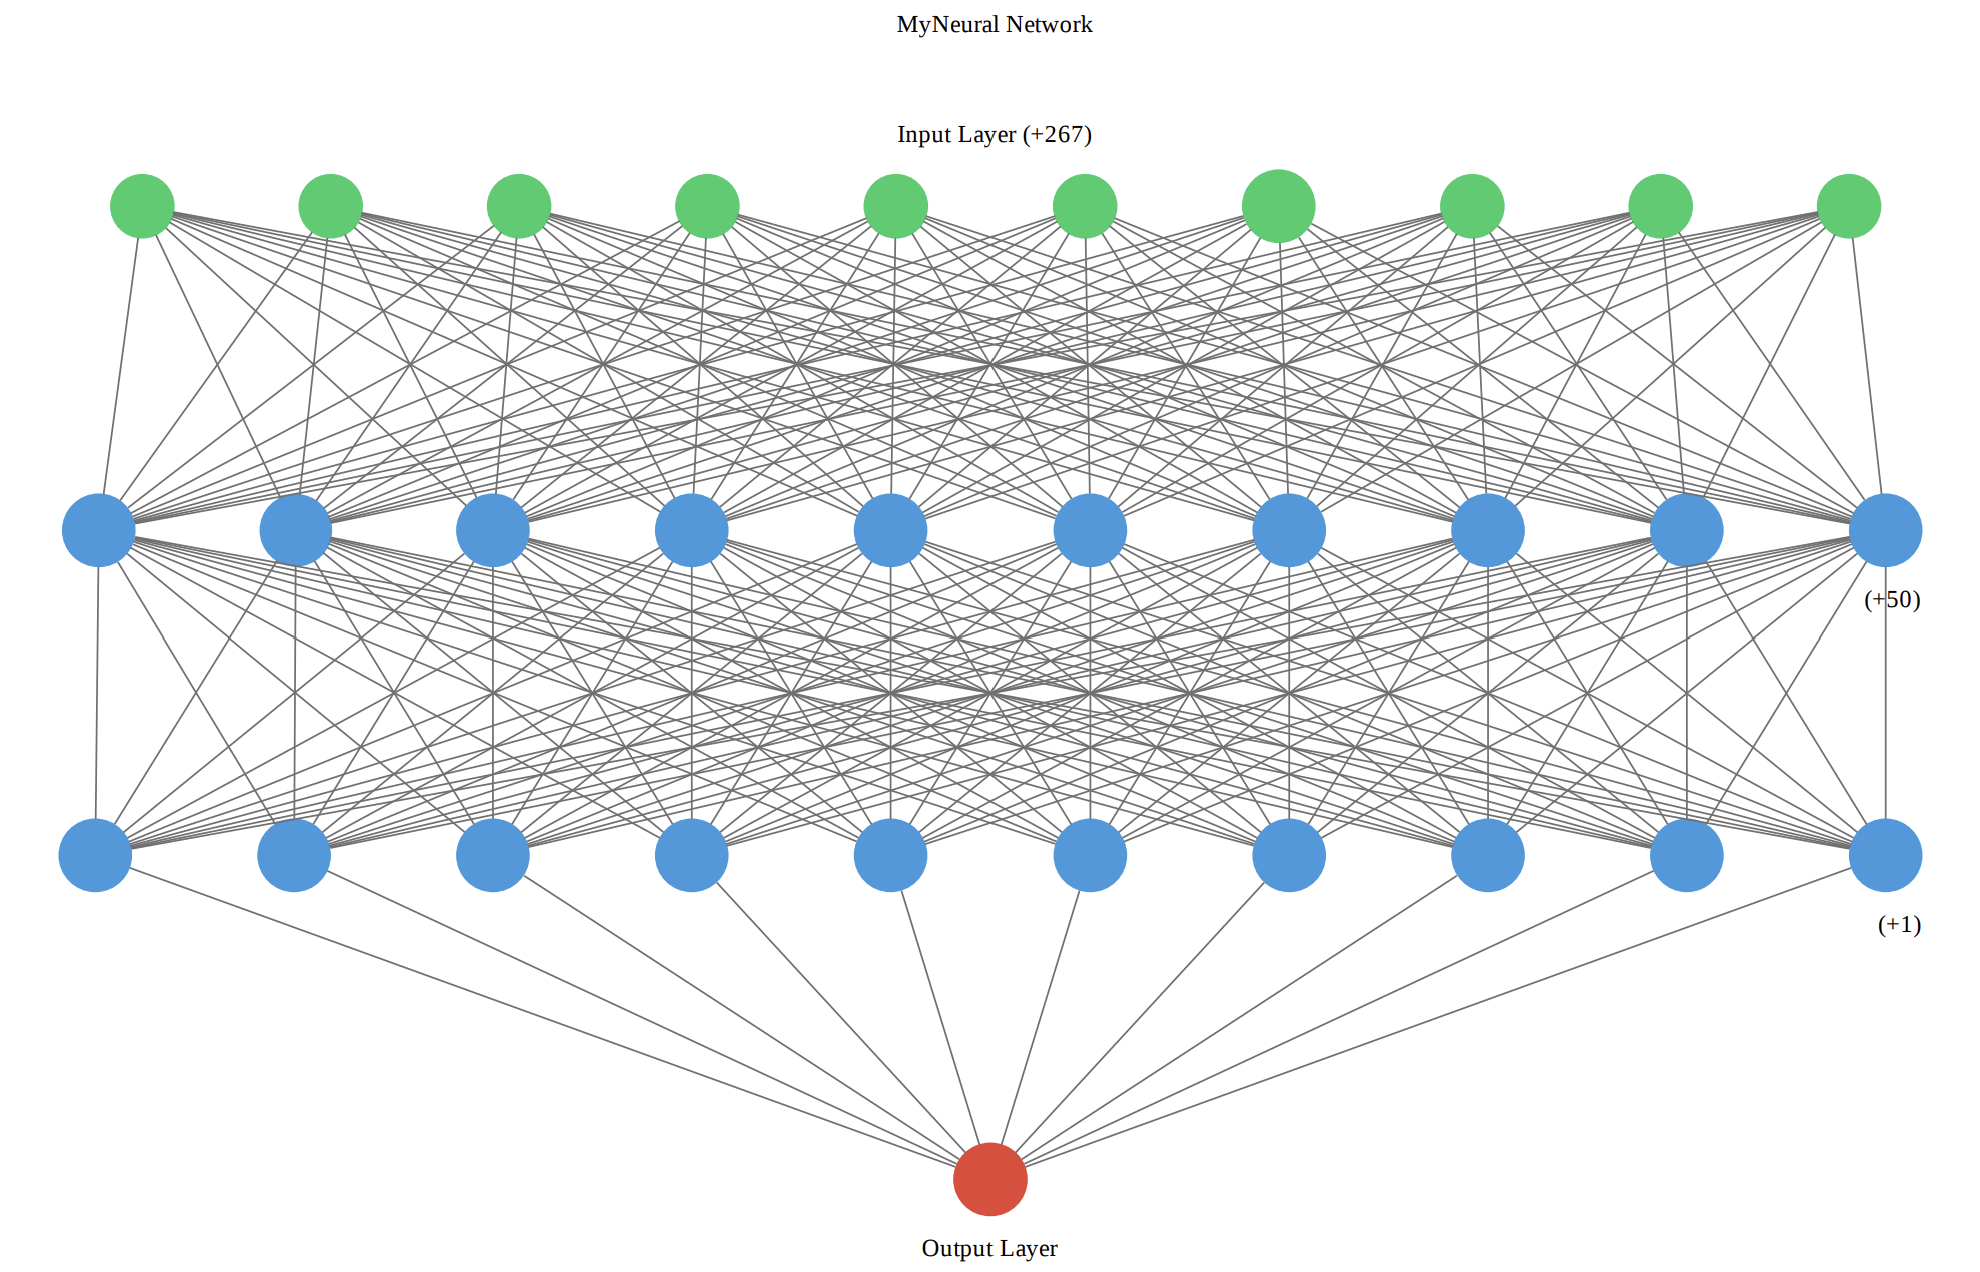

### KNN


In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
# Create a KNN classifier object
knn = KNeighborsClassifier()

# We will try a range of values for the number of neighbors (k) and the weights (uniform or distance)
scores = []
for k in range(1, 31):
    for weights in ['uniform', 'distance']:
        knn.set_params(n_neighbors=k, weights=weights)
        scores.append(np.mean(cross_val_score(knn, X_train, y_train, cv=5)))

# Find the combination of k and weights that resulted in the highest mean cross-validation score
best_index = np.argmax(scores)
best_k = (best_index // 2) + 1
best_weights = ['uniform', 'distance'][best_index % 2]

# Re-train the model with the best hyperparameters and evaluate on the test set
knn.set_params(n_neighbors=best_k, weights=best_weights)
knn.fit(X_train, y_train)
test_score = knn.score(X_test, y_test)

print(f'Best k: {best_k}')
print(f'Best weights: {best_weights}')
print(f'Test score: {test_score:.2f}')


Best k: 6
Best weights: distance
Test score: 0.65


In [ ]:
knnfinal=KNeighborsClassifier(n_neighbors=6,weights='distance')
knnfinal.fit(X_train,y_train)
ypredtest2=knnfinal.predict(X_test)
evalknn=model_evaluation(y_test,ypredtest2,'KNN')
print(evalknn)

{'Model': 'KNN', 'Accuracy': 0.65, 'Recall': 0.55, 'Precision': 0.6875, 'F1-score': 0.6111111111111112, 'AUC': 0.65, 'Confusion matrix': array([[15,  5],
       [ 9, 11]])}


### SVM

In [ ]:
from sklearn.svm import SVC

# Set up the grid search
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]}
grid = GridSearchCV(SVC(random_state=42), param_grid, cv=5)

# Use grid search to find the best hyperparameters
grid.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid.best_params_
print(f'Best parameters: {best_params}')

# Re-train the model with the best hyperparameters and evaluate on the test set
model = SVC(**best_params)
model.fit(X_train, y_train)
test_score = model.score(X_test, y_test)
print(f'Test score: {test_score:.2f}')


Best parameters: {'C': 0.1, 'gamma': 0.1}
Test score: 0.78


In [ ]:
SVMfinal=SVC(C=0.1,gamma=0.1)
SVMfinal.fit(X_train,y_train)
ypredtest3=SVMfinal.predict(X_test)
evalSVM=model_evaluation(y_test,ypredtest3,'SVM')
print(evalSVM)

{'Model': 'SVM', 'Accuracy': 0.775, 'Recall': 0.6, 'Precision': 0.9230769230769231, 'F1-score': 0.7272727272727274, 'AUC': 0.775, 'Confusion matrix': array([[19,  1],
       [ 8, 12]])}


## Model comparaison

Now we can compare the different results and conlcude about the best model, i will start by creating a dataframe containing all the information and then visualize the different values

In [ ]:
def compare_models(models):
    metric_names = ['Accuracy', 'Recall', 'Precision', 'F1-score', 'AUC']
    
    results = pd.DataFrame(columns=['Model'] + metric_names + ['Confusion matrix'])
    
    for i, model in enumerate(models):
        results.loc[i] = [model['Model']] + [model[metric] for metric in metric_names] + [model['Confusion matrix']]
    
    return results


In [ ]:
result=compare_models([evaldectree,ann[3],evalknn,evalSVM])
print(result)

           Model  Accuracy  Recall  Precision  F1-score      AUC  \
0  Decision Tree     0.750    0.50   1.000000  0.666667  0.75000   
1            ANN     0.725    0.55   0.846154  0.666667  0.81875   
2            KNN     0.650    0.55   0.687500  0.611111  0.65000   
3            SVM     0.775    0.60   0.923077  0.727273  0.77500   

      Confusion matrix  
0  [[20, 0], [10, 10]]  
1   [[18, 2], [9, 11]]  
2   [[15, 5], [9, 11]]  
3   [[19, 1], [8, 12]]  


F1 score

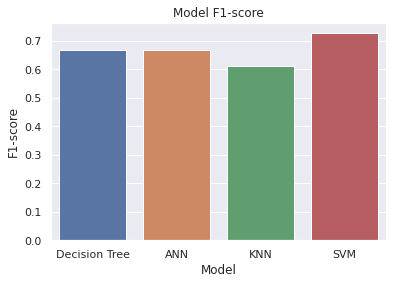

In [ ]:
import seaborn as sns

# Create a box plot
sns.barplot(x='Model', y='F1-score', data=result)

# Add a title and show the plot
plt.title('Model F1-score')
plt.show()


Accuracy

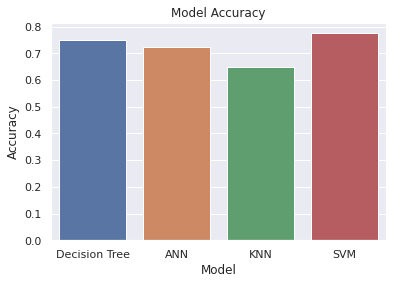

In [ ]:
# Create a box plot
sns.barplot(x='Model', y='Accuracy', data=result)

# Add a title and show the plot
plt.title('Model Accuracy')
plt.show()

Precision

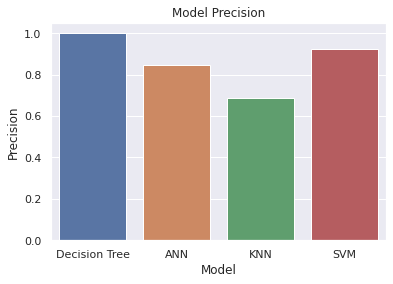

In [ ]:
# Create a box plot
sns.barplot(x='Model', y='Precision', data=result)

# Add a title and show the plot
plt.title('Model Precision')
plt.show()

Recall

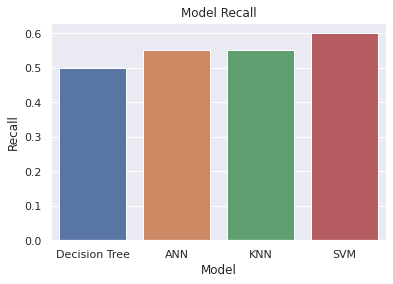

In [ ]:
# Create a box plot
sns.barplot(x='Model', y='Recall', data=result)

# Add a title and show the plot
plt.title('Model Recall')
plt.show()

AUC

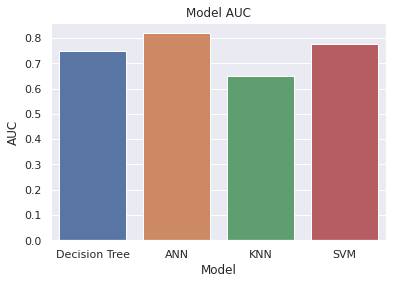

In [ ]:
# Create a box plot
sns.barplot(x='Model', y='AUC', data=result)

# Add a title and show the plot
plt.title('Model AUC')
plt.show()

Based on the given results, it appears that the best model for the malign mole image detector is the Support Vector Machine (SVM). This is because it has the highest accuracy, F1-score, and area under the curve (AUC) combined results.

There are several reasons why the SVM model may be the best choice in this case. Firstly, the high accuracy and F1-score indicate that the model is able to correctly classify a large number of cases and balance precision and recall well. The high AUC also suggests that the model is able to distinguish between malign and benign moles with a high degree of certainty.

Additionally, the use of more data to optimize the results may further improve the performance of the SVM model. This is because the SVM model is able to effectively handle large datasets and can potentially learn more complex patterns in the data.

Overall, the SVM model is a strong choice for the malign mole image detector due to its high accuracy, F1-score, and AUC, as well as its ability to potentially benefit from the use of additional data.

# This work was made by Julien Séailles, i sincerely hope that you liked it and i thank you for the time you have taken to go through this work. i wish you a pleasant day. You can find the original notebook on collab at this adress : https://colab.research.google.com/drive/11ouwCUhuBnGndOb2US5dnuGDMYad8p6a?usp=sharing

